# get bachground density rho_s based on Winters et al. 1995

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import xarray as xr
# import MITgcmutils as mitgcm
import xmitgcm 

%matplotlib inline
import os
import imageio
import pandas as pd

import sys
from tqdm import tqdm
import psutil
import math

# 1. pre select data

In [2]:
def get_ram_info():
    """
    Retrieves and prints detailed information about the system's RAM usage.
    """
    mem = psutil.virtual_memory()
    
    # Helper function to format bytes into human-readable units (GB)
    bytes_to_gb = lambda bytes_val: math.ceil(bytes_val / (1024**3))

    # print(f"Total RAM      : {bytes_to_gb(mem.total)} GB")
    # print(f"Available RAM  : {bytes_to_gb(mem.available)} GB")
    print(f"Used RAM  : {mem.used}")
    # print(f"Used RAM       : {bytes_to_gb(mem.used)} GB")
    # print(f"Used Percentage: {mem.percent}%")

get_ram_info()

Used RAM  : 5300252672


## 1.1 load data

In [3]:
icase = '033'
# outs_sn
# ds_sn = xmitgcm.open_mdsdataset('/home/ceoas/liux8/work/basin_modes/sulu_sea/res100_runs/exp8_small_tides_0.01/',prefix=['outs_sn'])
ds_sn = xmitgcm.open_mdsdataset(f'/home/ceoas/liux8/work/basin_modes/sulu_sea/linear_tests/case_N2_fac_{icase}/',prefix=['outs_sn'])
# ds_eta = xmitgcm.open_mdsdataset('/home/ceoas/liux8/work/basin_modes/sulu_sea/res100_runs/exp7_cd_q_00025/',prefix=['outs_sn_etan'])
ds_sn

<xarray.Dataset> Size: 2TB
Dimensions:  (XC: 1520, YC: 1908, XG: 1520, YG: 1908, Z: 57, Zp1: 58, Zu: 57,
              Zl: 57, time: 571)
Coordinates: (12/37)
  * XC       (XC) >f4 6kB 112.5 112.5 112.5 112.5 ... 127.7 127.7 127.7 127.7
  * YC       (YC) >f4 8kB -3.295 -3.285 -3.275 -3.265 ... 15.76 15.77 15.77
  * XG       (XG) >f4 6kB 112.5 112.5 112.5 112.5 ... 127.7 127.7 127.7 127.7
  * YG       (YG) >f4 8kB -3.3 -3.29 -3.28 -3.27 ... 15.74 15.75 15.76 15.77
  * Z        (Z) >f4 228B -12.5 -37.5 -62.5 ... -4.062e+03 -4.453e+03 -4.908e+03
  * Zp1      (Zp1) >f4 232B 0.0 -25.0 -50.0 ... -4.247e+03 -4.658e+03 -5.158e+03
    ...       ...
    maskInW  (YC, XG) bool 3MB dask.array<chunksize=(1908, 1520), meta=np.ndarray>
    dxF      (YC, XC) >f4 12MB dask.array<chunksize=(1908, 1520), meta=np.ndarray>
    maskInC  (YC, XC) bool 3MB dask.array<chunksize=(1908, 1520), meta=np.ndarray>
    maskInS  (YG, XC) bool 3MB dask.array<chunksize=(1908, 1520), meta=np.ndarray>
    iter     (time) int64 5kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 5kB 00:00:00 00:03:00 ... 1 days 04:30:00
Data variables:
    UVEL     (time, Z, YC, XG) float32 378GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) float32 378GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) float32 378GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
    THETA    (time, Z, YC, XC) float32 378GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
    PHIHYD   (time, Z, YC, XC) float32 378GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(data_dir='/home/ceoas/l...

## 1.2 select sulu sea

In [4]:
# 4. Define a mask for the Sulu Sea region
mask_sulu = np.zeros_like(ds_sn.maskC.values[0,:,:])
lon = ds_sn.XC.values
lat = ds_sn.YC.values
mask_sea = ds_sn.maskC.values[0, :,:,]
depth_sea = ds_sn.Depth.values
# Define the polygon vertices for the Sulu Sea region
polygon = np.array([[119.7477305555556,5.019866666666666],
                    [120.7759136579978,5.474645071467973],
                    [122.0604127462074,6.418861725702965],
                    [122.0628562951826,6.950772011696411],
                    [122.4156305555556,7.857713888888888],
                    [123.2841972222222,8.224422222222222],
                    [123.2738388888889,9.305238888888889],
                    [123.0141444444444,9.580508333333334],
                    [123.2125075318087,10.77780565549861],
                    [121.9560470708515,11.85454899091673],
                    [120.9629975202234,12.58813464766382],
                    [120.2369776182294,12.10162143969847],
                    [119.9644441358147,11.66278768318502],
                    [119.4982072167793,11.19294905649988],
                    [119.5408523724053,10.66721177108409],
                    [117.7072365775101,8.913243570406612],
                    [116.9942048191374,7.818840574887203],
                    [117.0953880245524,7.260348599583542],
                    [117.4610027777778,5.793652777777778],
                    [119.0369305555556,5.263388888888889],
                    [119.7477305555556,5.019866666666666]
])

path = Path(polygon)
for i in tqdm(range(mask_sulu.shape[0])):
    for j in range(mask_sulu.shape[1]):
        if path.contains_point((lon[j], lat[i])):
            mask_sulu[i,j] = 1   
            if (mask_sea[i,j] ==0)|(depth_sea[i,j] <200):
                mask_sulu[i,j] = 0

100%|██████████| 1908/1908 [00:08<00:00, 235.43it/s]


In [5]:
# Find the minimum rectangular range that contains all True values in mask_sulu
# Get indices where mask_sulu == 1 (True)
i_indices, j_indices = np.where(mask_sulu == 1)

if len(i_indices) > 0:
    # Find the minimum and maximum row and column indices
    i_min = np.min(i_indices)
    i_max = np.max(i_indices)
    j_min = np.min(j_indices)
    j_max = np.max(j_indices)
    
    print(f"Minimum rectangular range indices:")
    print(f"  Row range: [{i_min}, {i_max}]")
    print(f"  Column range: [{j_min}, {j_max}]")
    print(f"\nResult as tuple: (i_min={i_min}, i_max={i_max}, j_min={j_min}, j_max={j_max})")
    
    # Store the result
    mask_sulu_bbox = mask_sulu[i_min:i_max+1, j_min: j_max+1]
else:
    print("No True values found in mask_sulu")
    mask_sulu_bbox = None


Minimum rectangular range indices:
  Row range: [836, 1579]
  Column range: [458, 1077]

Result as tuple: (i_min=836, i_max=1579, j_min=458, j_max=1077)


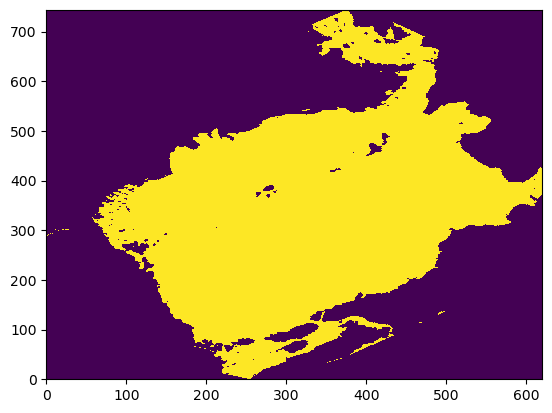

In [6]:
plt.pcolormesh(mask_sulu_bbox)
# plt.colorbar()

# 2. get APE density profile 

## 2.1 get data of one time snapshot

In [7]:
# Get temperature field at time=0 and extract data within the specified range
# Define the index range
i_min = 836
i_max = 1579
j_min = 458
j_max = 1077

# Get temperature at time=0
theta_t0 = ds_sn.THETA.isel(time=0)

# Extract temperature data within the specified range
# Note: xarray uses isel for integer indexing, and we need to include the end index
theta_subset = theta_t0.isel(YC=slice(i_min, i_max+1), XC=slice(j_min, j_max+1))

# Also get as numpy array if needed
theta_subset_array = theta_subset.values

print(f"Temperature field shape: {theta_t0.shape}")
print(f"Subset shape: {theta_subset.shape}")
print(f"Subset range: i=[{i_min}, {i_max}], j=[{j_min}, {j_max}]")

theta_subset_array[theta_subset_array == 0] = np.nan
rho0 = 1026.5
T0 = 5
alpha = 2e-4
rho_sulu = rho0*(1-alpha*(theta_subset_array-T0))
g=9.81

Temperature field shape: (57, 1908, 1520)
Subset shape: (57, 744, 620)
Subset range: i=[836, 1579], j=[458, 1077]


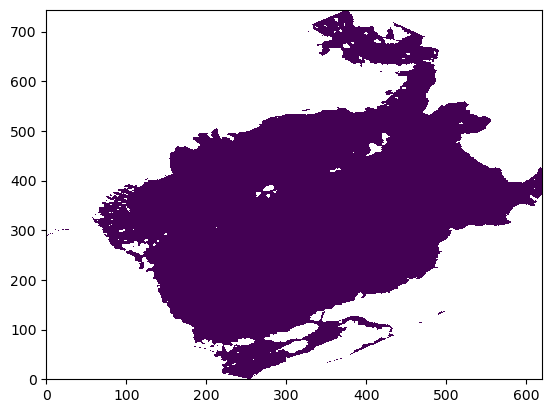

In [8]:
theta_sulu_surface = theta_subset_array[0,:,:]*mask_sulu_bbox

theta_sulu_surface[theta_sulu_surface == 0] = np.nan

plt.pcolormesh(theta_sulu_surface)

In [9]:
# def compute_background_PE(ds, rho, i_min,i_max,j_min,j_max, rA_name='rA', drC_name='drF',
#                           hFacC_name='hFacC', g=9.81, time_index=None):
def compute_background_PE(rho,    rA, hFacC, vol, mask,  V_ref_k, z_centers,):
    """
    Compute background potential energy Eb from dataset `ds`.
    Returns Eb (J) and reference profile (rho_ref, z_ref, V_ref).
    """
    # get fields
    rho_t = xr.DataArray(rho, dims = ('Z','YC','XC'))
    # rA = ds[rA_name].isel(YC=slice(i_min, i_max+1), XC=slice(j_min, j_max+1))
    # drC = ds[drC_name]    # 1D vertical cell thickness (k,)
    # hFacC = ds.hFacC.isel(YC=slice(i_min, i_max+1), XC=slice(j_min, j_max+1))

    # # ensure drC is cell-centered 1D array
    # dr = drC
    # # compute cell center z coordinates (assuming drC gives thickness and we have faces)
    # # simple cumulative: top of domain z_top = 0, compute centers downward
    # # If ds contains zC or zMid use that instead; here we compute:
    # z_faces = ds.Zp1.values
    # # center heights: midpoints between faces; note sign convention: positive upward?
    # z_centers = ds.Z.values

    # Expand dr and z to 3D shape of rho_t for volume computations
    # rA has dims (j,i); expand to (k,j,i)
    # hFacC maybe (k,j,i)
    # create 3d dr array broadcastable to rho
    # find spatial dims of rho_t
    spatial_dims = rho_t.dims  # expect (k,j,i) or similar
    k_dim = spatial_dims[0]    # assume vertical is first dim; adapt if necessary
    # Broadcast dr (1D) to rho_t shape
    # dr_3d = xr.DataArray(dr.values, dims=(k_dim,), coords={k_dim: ds[drC_name].coords[drC_name]})
    # dr_3d = dr_3d.broadcast_like(rho_t)

    # Build rA 3D
    rA_3d = rA.broadcast_like(rho_t)

    hFacC_3d = hFacC.broadcast_like(rho_t)

    # parcel volumes and densities (flatten)
    # vol = (rA_3d.values * dr_3d.values * hFacC_3d.values).ravel()   # 1D numpy array
    
    dens = rho_t.values.ravel()

    # remove zero-volume parcels (if any)
    # mask = vol > 0
    # vol = vol[mask]
    dens = dens[mask]

    # total horizontal area A_tot (sum rA over i,j)
    # A_tot = rA.sum().compute().item()

    # target reference layer volumes: V_ref_k = A_tot * dr_k (dr_k are ds[drC_name])
    # V_ref_k = A_tot * dr.values   # numpy 1D length K
    # V_ref_k = np.zeros(dr.shape[0])
    # for k in range(dr.shape[0]):
    #     V_ref_k[k] = np.sum((rA_3d.astype(np.double).values * dr_3d.astype(np.double).values * hFacC_3d.astype(np.double).values)[k,:,:])


    # prepare sorted parcels by density (lightest -> heaviest)
    order = np.argsort(dens)   # ascending
    dens_sorted = dens[order]
    vol_sorted = vol[order]
    np.sum(vol_sorted)
    # fig, ax = plt.subplots(2,1,figsize=(8,6))
    # ax[0].plot(dens)
    # ax[0].set_xlim(0,20000)
    # plt.plot(dens_sorted)
    # ax[1].set_xlim(0,20000)
    # fig, ax = plt.subplots(2,1,figsize=(8,6))
    # ax[0].plot(vol)
    # # ax[0].set_xlim(0,20000)
    # ax[1].plot(vol_sorted)

    # fill reference layers from bottom to top:
    # Winters stacks heaviest bottom; since dens_sorted is ascending (light->heavy),
    # fill from the end for bottom layers. Simpler: reverse to heavy-first.
    dens_h = dens_sorted[::-1]
    vol_h = vol_sorted[::-1]   # now heavy -> light

    K = len(V_ref_k)
    rho_ref = np.zeros(K)
    z_ref = z_centers  # numpy array of centers
    Vref_used = V_ref_k.copy()

    idx = 0         # index in dens_h parcels
    vol_left = vol_h[idx] if len(vol_h)>0 else 0.0

    # iterative fill each reference layer from bottom (k=0 bottom? depends on z ordering)
    # Here we assume dr array was from top to bottom; z_centers from top->down.
    # We want k indices bottom->top, so reverse arrays:
    Vref_bottomup = V_ref_k[::-1]
    z_bottomup = z_centers[::-1]

    # sumV_domain = 0
    for kk in range(K):
        # print(kk,sumV_domain)
        V_target = Vref_bottomup[kk]
        sum_rhoV = 0.0
        sumV_filled = 0.0
        # fill this layer
        # while sumV_filled < V_target:
        while V_target-sumV_filled>0.1:
            if idx >= len(dens_h):
                print(idx)
                print(len(dens_h))
                raise RuntimeError(f"Ran out of parcels while filling reference layers.{idx}")
            take = min(vol_left, V_target - sumV_filled)
            # print(take, vol_left, V_target - sumV_filled)
            sum_rhoV += dens_h[idx] * take
            sumV_filled += take
            vol_left -= take
            # sumV_domain += take
            if vol_left <= 1e-16:
                # move to next parcel
                idx += 1
                if idx < len(vol_h):
                    vol_left = vol_h[idx]
            
        rho_ref[K-1-kk] = sum_rhoV / V_target  # assign back in top->bottom order
    
    # compute Eb:
    # Use z_centers and V_ref_k with same ordering as rho_ref
    # Decide z sign: Winters uses z positive upward. If z_centers from top=0 increasing downward, convert to actual heights.
    # Here we assume z_centers is depth increasing downward; convert to height measured from bottom or top as needed.
    # We'll assume z_centers are heights above bottom. Adjust if needed.
    Eb = g * np.sum(rho_ref * z_centers * V_ref_k)

    # return results
    return Eb, dict(rho_ref=rho_ref, z_ref=z_centers, V_ref=V_ref_k)

# Example usage:
# ds = xmitgcm.open_mdsdataset(mdl_dir, prefix=['THETA','S','rA','drC','hFacC'], geometry='cartesian')
# Eb, ref = compute_background_PE(ds_sn, rho_sulu,i_min,i_max,j_min,j_max)   # or rho from equation of state
# print("Background PE (J):", Eb)


In [11]:
# icase='033'
ds = ds_sn

nt =571

i_min = 836
i_max = 1579
j_min = 458
j_max = 1077
# i_min = 836
# i_max = 836+200+400
# j_min = 449
# j_max = 449+100+500

# rho = rho_sulu[:,100:120,200:230]

rho_t = xr.DataArray(rho_sulu, dims = ('Z','YC','XC'))
# rA = ds['rA'].isel(YC=slice(i_min+100, i_min+120), XC=slice(j_min+200, j_min+230))
rA = ds['rA'].isel(YC=slice(i_min, i_max+1), XC=slice(j_min, j_max+1))*mask_sulu_bbox
drC = ds['drF']    # 1D vertical cell thickness (k,)
hFacC = ds.hFacC.isel(YC=slice(i_min, i_max+1), XC=slice(j_min, j_max+1))

# ensure drC is cell-centered 1D array
dr = drC
# compute cell center z coordinates (assuming drC gives thickness and we have faces)
# simple cumulative: top of domain z_top = 0, compute centers downward
# If ds contains zC or zMid use that instead; here we compute:
z_faces = ds.Zp1.values
# center heights: midpoints between faces; note sign convention: positive upward?
z_centers = ds.Z.values

# Expand dr and z to 3D shape of rho_t for volume computations
# rA has dims (j,i); expand to (k,j,i)
# hFacC maybe (k,j,i)
# create 3d dr array broadcastable to rho
# find spatial dims of rho_t
spatial_dims = rho_t.dims  # expect (k,j,i) or similar
k_dim = spatial_dims[0]    # assume vertical is first dim; adapt if necessary
# Broadcast dr (1D) to rho_t shape
dr_3d = xr.DataArray(dr.values, dims=(k_dim,), coords={k_dim: ds['drF'].coords['drF']})
dr_3d = dr_3d.broadcast_like(rho_t)

# Build rA 3D
rA_3d = rA.broadcast_like(rho_t)

hFacC_3d = hFacC.broadcast_like(rho_t)

# parcel volumes and densities (flatten)
vol = (rA_3d.astype(np.longdouble).values * dr_3d.astype(np.longdouble).values * hFacC_3d.astype(np.longdouble).values).ravel()   # 1D numpy array
print(vol.shape)
# dens = rho_t.values.ravel()
mask = vol > 0
vol = vol[mask]
# dens = dens[mask]
print(vol.shape)

# total horizontal area A_tot (sum rA over i,j)
# A_tot = rA.sum().compute().item()

# target reference layer volumes: V_ref_k = A_tot * dr_k (dr_k are ds[drC_name])
# V_ref_k = A_tot * dr.values   # numpy 1D length K
V_ref_k = np.zeros(dr.shape[0])
for k in tqdm(range(dr.shape[0])):
    V_ref_k[k] = np.sum((rA_3d.astype(np.longdouble).values * dr_3d.astype(np.longdouble).values * hFacC_3d.astype(np.longdouble).values)[k,:,:])
    # print(k,V_ref_k[k])

Z = z_centers
# rho_ref_t=[]
# theta_t2 = []
for it in tqdm(range(0,nt)):
# for it in tqdm(range(0,10)):
    # print(it)

    theta_t0 = ds_sn.THETA.isel(time=it)
    theta_subset = theta_t0.isel(YC=slice(i_min, i_max+1), XC=slice(j_min, j_max+1))
    theta_subset_array = theta_subset.values

    rho_sulu_t = rho0*(1-alpha*(theta_subset_array-T0))
    Eb, ref = compute_background_PE(rho_sulu_t, rA, hFacC, vol, mask, V_ref_k, z_centers, )   # or rho from equation of state
    # rho_ref_t.append(ref['rho_ref'])
    theta_ref = 1/alpha*(1-ref['rho_ref']/rho0)+T0
    
    # Z = z_centers
    # t = np.arange(0,rho_ref_t2.shape[0], 1)
    
    theta_ref_ds = xr.Dataset(
        {
            "theta_ref": (("Z"), theta_ref)
        },
        coords={
            "Z": Z
        }
    )
    # theta_ref_ds.to_netcdf('theta_ref/theta_ref_exp7_ctrl.nc')
    theta_ref_ds.to_netcdf(f'theta_ref_linear_case_{icase}/theta_ref_t_{it:03d}.nc','w')
    get_ram_info()
    # theta_t2.append(theta_subset_array)

(26292960,)
(7775246,)


  0%|          | 1/571 [00:11<1:50:08, 11.59s/it]

Used RAM  : 6855467008


  0%|          | 2/571 [00:23<1:49:23, 11.54s/it]

Used RAM  : 6857445376


  1%|          | 3/571 [00:34<1:48:26, 11.46s/it]

Used RAM  : 6618705920


  1%|          | 4/571 [00:46<1:49:15, 11.56s/it]

Used RAM  : 6359166976


  1%|          | 5/571 [00:57<1:49:50, 11.64s/it]

Used RAM  : 4966604800


  1%|          | 6/571 [01:09<1:50:12, 11.70s/it]

Used RAM  : 5013860352


  1%|          | 7/571 [01:22<1:51:38, 11.88s/it]

Used RAM  : 4591308800


  1%|▏         | 8/571 [01:34<1:53:42, 12.12s/it]

Used RAM  : 4585345024


  2%|▏         | 9/571 [01:47<1:56:22, 12.42s/it]

Used RAM  : 4583026688


  2%|▏         | 10/571 [02:00<1:56:28, 12.46s/it]

Used RAM  : 4617887744


  2%|▏         | 11/571 [02:12<1:55:48, 12.41s/it]

Used RAM  : 4623069184


  2%|▏         | 12/571 [02:24<1:54:49, 12.33s/it]

Used RAM  : 4603695104


  2%|▏         | 13/571 [02:37<1:56:17, 12.50s/it]

Used RAM  : 4598976512


  2%|▏         | 14/571 [02:49<1:55:31, 12.44s/it]

Used RAM  : 4610002944


  3%|▎         | 15/571 [03:01<1:53:35, 12.26s/it]

Used RAM  : 4593729536


  3%|▎         | 16/571 [03:14<1:55:49, 12.52s/it]

Used RAM  : 4580159488


  3%|▎         | 17/571 [03:27<1:56:49, 12.65s/it]

Used RAM  : 4557783040


  3%|▎         | 18/571 [03:40<1:57:44, 12.78s/it]

Used RAM  : 4556886016


  3%|▎         | 19/571 [03:53<1:57:45, 12.80s/it]

Used RAM  : 4549341184


  4%|▎         | 20/571 [04:06<1:57:02, 12.74s/it]

Used RAM  : 4558807040


  4%|▎         | 21/571 [04:19<1:56:38, 12.73s/it]

Used RAM  : 4632936448


  4%|▍         | 22/571 [04:32<1:58:06, 12.91s/it]

Used RAM  : 4570349568


  4%|▍         | 23/571 [04:45<1:57:12, 12.83s/it]

Used RAM  : 4549140480


  4%|▍         | 24/571 [04:57<1:57:12, 12.86s/it]

Used RAM  : 4557950976


  4%|▍         | 25/571 [05:11<1:57:31, 12.92s/it]

Used RAM  : 4600238080


  5%|▍         | 26/571 [05:24<1:58:31, 13.05s/it]

Used RAM  : 4601405440


  5%|▍         | 27/571 [05:37<1:58:21, 13.05s/it]

Used RAM  : 4570914816


  5%|▍         | 28/571 [05:50<1:57:51, 13.02s/it]

Used RAM  : 4570361856


  5%|▌         | 29/571 [06:03<1:58:29, 13.12s/it]

Used RAM  : 5014110208


  5%|▌         | 30/571 [06:17<1:59:40, 13.27s/it]

Used RAM  : 4580712448


  5%|▌         | 31/571 [06:31<2:01:08, 13.46s/it]

Used RAM  : 4590743552


  6%|▌         | 32/571 [06:44<2:01:01, 13.47s/it]

Used RAM  : 4590841856


  6%|▌         | 33/571 [06:58<2:00:44, 13.47s/it]

Used RAM  : 4593090560


  6%|▌         | 34/571 [07:12<2:01:28, 13.57s/it]

Used RAM  : 4573450240


  6%|▌         | 35/571 [07:25<2:01:25, 13.59s/it]

Used RAM  : 4567486464


  6%|▋         | 36/571 [07:39<2:01:27, 13.62s/it]

Used RAM  : 4547366912


  6%|▋         | 37/571 [07:53<2:01:22, 13.64s/it]

Used RAM  : 4552790016


  7%|▋         | 38/571 [08:07<2:02:06, 13.75s/it]

Used RAM  : 4561227776


  7%|▋         | 39/571 [08:20<2:01:01, 13.65s/it]

Used RAM  : 4555366400


  7%|▋         | 40/571 [08:35<2:03:42, 13.98s/it]

Used RAM  : 4570214400


  7%|▋         | 41/571 [08:49<2:03:34, 13.99s/it]

Used RAM  : 4558655488


  7%|▋         | 42/571 [09:04<2:06:55, 14.40s/it]

Used RAM  : 4551770112


  8%|▊         | 43/571 [09:19<2:09:07, 14.67s/it]

Used RAM  : 4565381120


  8%|▊         | 44/571 [09:34<2:09:42, 14.77s/it]

Used RAM  : 4545699840


  8%|▊         | 45/571 [09:49<2:08:59, 14.71s/it]

Used RAM  : 4562771968


  8%|▊         | 46/571 [10:03<2:06:07, 14.42s/it]

Used RAM  : 4568813568


  8%|▊         | 47/571 [10:16<2:03:38, 14.16s/it]

Used RAM  : 4561248256


  8%|▊         | 48/571 [10:30<2:02:49, 14.09s/it]

Used RAM  : 4663439360


  9%|▊         | 49/571 [10:44<2:01:52, 14.01s/it]

Used RAM  : 4581150720


  9%|▉         | 50/571 [10:59<2:03:04, 14.17s/it]

Used RAM  : 4605235200


  9%|▉         | 51/571 [11:13<2:03:56, 14.30s/it]

Used RAM  : 4695834624


  9%|▉         | 52/571 [11:27<2:03:30, 14.28s/it]

Used RAM  : 4663906304


  9%|▉         | 53/571 [11:41<2:01:03, 14.02s/it]

Used RAM  : 4717867008


  9%|▉         | 54/571 [11:56<2:02:42, 14.24s/it]

Used RAM  : 4664082432


 10%|▉         | 55/571 [12:09<2:01:13, 14.10s/it]

Used RAM  : 4641210368


 10%|▉         | 56/571 [12:23<1:59:26, 13.92s/it]

Used RAM  : 4654456832


 10%|▉         | 57/571 [12:36<1:58:23, 13.82s/it]

Used RAM  : 4648148992


 10%|█         | 58/571 [12:50<1:56:45, 13.66s/it]

Used RAM  : 4607897600


 10%|█         | 59/571 [13:02<1:54:13, 13.39s/it]

Used RAM  : 4593238016


 11%|█         | 60/571 [13:15<1:53:07, 13.28s/it]

Used RAM  : 4639981568


 11%|█         | 61/571 [13:30<1:55:15, 13.56s/it]

Used RAM  : 4666880000


 11%|█         | 62/571 [13:44<1:56:04, 13.68s/it]

Used RAM  : 4733796352


 11%|█         | 63/571 [13:58<1:56:51, 13.80s/it]

Used RAM  : 4869480448


 11%|█         | 64/571 [14:11<1:55:46, 13.70s/it]

Used RAM  : 4619874304


 11%|█▏        | 65/571 [14:25<1:54:41, 13.60s/it]

Used RAM  : 4645543936


 12%|█▏        | 66/571 [14:37<1:52:43, 13.39s/it]

Used RAM  : 4542832640


 12%|█▏        | 67/571 [14:51<1:53:15, 13.48s/it]

Used RAM  : 4547567616


 12%|█▏        | 68/571 [15:04<1:52:10, 13.38s/it]

Used RAM  : 4537159680


 12%|█▏        | 69/571 [15:18<1:53:05, 13.52s/it]

Used RAM  : 4525379584


 12%|█▏        | 70/571 [15:31<1:52:10, 13.43s/it]

Used RAM  : 4512751616


 12%|█▏        | 71/571 [15:45<1:52:27, 13.49s/it]

Used RAM  : 4512051200


 13%|█▎        | 72/571 [15:58<1:51:10, 13.37s/it]

Used RAM  : 4514971648


 13%|█▎        | 73/571 [16:12<1:51:29, 13.43s/it]

Used RAM  : 4511850496


 13%|█▎        | 74/571 [16:26<1:53:10, 13.66s/it]

Used RAM  : 4508127232


 13%|█▎        | 75/571 [16:40<1:55:07, 13.93s/it]

Used RAM  : 4486221824


 13%|█▎        | 76/571 [16:54<1:54:09, 13.84s/it]

Used RAM  : 4491497472


 13%|█▎        | 77/571 [17:07<1:52:56, 13.72s/it]

Used RAM  : 4493049856


 14%|█▎        | 78/571 [17:22<1:53:56, 13.87s/it]

Used RAM  : 4493643776


 14%|█▍        | 79/571 [17:35<1:51:18, 13.57s/it]

Used RAM  : 4496920576


 14%|█▍        | 80/571 [17:48<1:51:17, 13.60s/it]

Used RAM  : 4484710400


 14%|█▍        | 81/571 [18:02<1:52:28, 13.77s/it]

Used RAM  : 4506423296


 14%|█▍        | 82/571 [18:16<1:51:38, 13.70s/it]

Used RAM  : 4486656000


 15%|█▍        | 83/571 [18:30<1:51:06, 13.66s/it]

Used RAM  : 4488265728


 15%|█▍        | 84/571 [18:43<1:51:11, 13.70s/it]

Used RAM  : 4497465344


 15%|█▍        | 85/571 [18:57<1:49:51, 13.56s/it]

Used RAM  : 4491714560


 15%|█▌        | 86/571 [19:10<1:48:55, 13.48s/it]

Used RAM  : 4491198464


 15%|█▌        | 87/571 [19:24<1:49:15, 13.54s/it]

Used RAM  : 4479500288


 15%|█▌        | 88/571 [19:37<1:49:24, 13.59s/it]

Used RAM  : 4481654784


 16%|█▌        | 89/571 [19:51<1:49:38, 13.65s/it]

Used RAM  : 4489310208


 16%|█▌        | 90/571 [20:04<1:48:32, 13.54s/it]

Used RAM  : 4491005952


 16%|█▌        | 91/571 [20:18<1:48:15, 13.53s/it]

Used RAM  : 4487323648


 16%|█▌        | 92/571 [20:31<1:48:23, 13.58s/it]

Used RAM  : 4477431808


 16%|█▋        | 93/571 [20:45<1:48:11, 13.58s/it]

Used RAM  : 4486475776


 16%|█▋        | 94/571 [20:59<1:49:11, 13.74s/it]

Used RAM  : 4484616192


 17%|█▋        | 95/571 [21:13<1:49:02, 13.74s/it]

Used RAM  : 4501196800


 17%|█▋        | 96/571 [21:27<1:50:00, 13.90s/it]

Used RAM  : 4488536064


 17%|█▋        | 97/571 [21:41<1:49:00, 13.80s/it]

Used RAM  : 4499800064


 17%|█▋        | 98/571 [21:54<1:48:08, 13.72s/it]

Used RAM  : 4536528896


 17%|█▋        | 99/571 [22:08<1:48:54, 13.84s/it]

Used RAM  : 4539699200


 18%|█▊        | 100/571 [22:22<1:47:28, 13.69s/it]

Used RAM  : 4549279744


 18%|█▊        | 101/571 [22:35<1:47:00, 13.66s/it]

Used RAM  : 4526428160


 18%|█▊        | 102/571 [22:49<1:47:25, 13.74s/it]

Used RAM  : 4503621632


 18%|█▊        | 103/571 [23:03<1:46:33, 13.66s/it]

Used RAM  : 4525858816


 18%|█▊        | 104/571 [23:16<1:45:44, 13.58s/it]

Used RAM  : 4507283456


 18%|█▊        | 105/571 [23:30<1:45:24, 13.57s/it]

Used RAM  : 4515885056


 19%|█▊        | 106/571 [23:43<1:44:26, 13.48s/it]

Used RAM  : 4511506432


 19%|█▊        | 107/571 [23:57<1:44:36, 13.53s/it]

Used RAM  : 4516634624


 19%|█▉        | 108/571 [24:10<1:43:18, 13.39s/it]

Used RAM  : 4498608128


 19%|█▉        | 109/571 [24:23<1:42:48, 13.35s/it]

Used RAM  : 4502437888


 19%|█▉        | 110/571 [24:37<1:43:59, 13.53s/it]

Used RAM  : 4509843456


 19%|█▉        | 111/571 [24:50<1:43:10, 13.46s/it]

Used RAM  : 4504072192


 20%|█▉        | 112/571 [25:03<1:42:28, 13.40s/it]

Used RAM  : 4509507584


 20%|█▉        | 113/571 [25:17<1:42:45, 13.46s/it]

Used RAM  : 4518903808


 20%|█▉        | 114/571 [25:30<1:41:26, 13.32s/it]

Used RAM  : 4509216768


 20%|██        | 115/571 [25:44<1:41:38, 13.37s/it]

Used RAM  : 4505948160


 20%|██        | 116/571 [25:57<1:41:43, 13.42s/it]

Used RAM  : 4527669248


 20%|██        | 117/571 [26:11<1:41:52, 13.46s/it]

Used RAM  : 4517781504


 21%|██        | 118/571 [26:25<1:42:56, 13.63s/it]

Used RAM  : 4529553408


 21%|██        | 119/571 [26:38<1:40:55, 13.40s/it]

Used RAM  : 4517011456


 21%|██        | 120/571 [26:51<1:40:53, 13.42s/it]

Used RAM  : 4514750464


 21%|██        | 121/571 [27:04<1:39:59, 13.33s/it]

Used RAM  : 4517519360


 21%|██▏       | 122/571 [27:17<1:38:49, 13.21s/it]

Used RAM  : 4514766848


 22%|██▏       | 123/571 [27:30<1:38:39, 13.21s/it]

Used RAM  : 4518170624


 22%|██▏       | 124/571 [27:44<1:38:40, 13.25s/it]

Used RAM  : 4514623488


 22%|██▏       | 125/571 [27:57<1:39:19, 13.36s/it]

Used RAM  : 4507516928


 22%|██▏       | 126/571 [28:10<1:37:41, 13.17s/it]

Used RAM  : 4502142976


 22%|██▏       | 127/571 [28:24<1:38:30, 13.31s/it]

Used RAM  : 4522737664


 22%|██▏       | 128/571 [28:38<1:39:56, 13.54s/it]

Used RAM  : 4519567360


 23%|██▎       | 129/571 [28:52<1:41:30, 13.78s/it]

Used RAM  : 4532805632


 23%|██▎       | 130/571 [29:06<1:41:07, 13.76s/it]

Used RAM  : 4524724224


 23%|██▎       | 131/571 [29:19<1:40:29, 13.70s/it]

Used RAM  : 4515155968


 23%|██▎       | 132/571 [29:33<1:39:26, 13.59s/it]

Used RAM  : 4505047040


 23%|██▎       | 133/571 [29:46<1:38:37, 13.51s/it]

Used RAM  : 4547485696


 23%|██▎       | 134/571 [30:00<1:38:42, 13.55s/it]

Used RAM  : 4563353600


 24%|██▎       | 135/571 [30:13<1:38:16, 13.52s/it]

Used RAM  : 4555530240


 24%|██▍       | 136/571 [30:27<1:38:06, 13.53s/it]

Used RAM  : 4507074560


 24%|██▍       | 137/571 [30:40<1:38:06, 13.56s/it]

Used RAM  : 4500840448


 24%|██▍       | 138/571 [30:53<1:37:12, 13.47s/it]

Used RAM  : 4499431424


 24%|██▍       | 139/571 [31:07<1:37:57, 13.60s/it]

Used RAM  : 4511424512


 25%|██▍       | 140/571 [31:21<1:38:12, 13.67s/it]

Used RAM  : 4508131328


 25%|██▍       | 141/571 [31:34<1:37:04, 13.54s/it]

Used RAM  : 4509011968


 25%|██▍       | 142/571 [31:48<1:37:09, 13.59s/it]

Used RAM  : 4498776064


 25%|██▌       | 143/571 [32:02<1:37:32, 13.67s/it]

Used RAM  : 4502601728


 25%|██▌       | 144/571 [32:15<1:36:12, 13.52s/it]

Used RAM  : 4501909504


 25%|██▌       | 145/571 [32:29<1:36:36, 13.61s/it]

Used RAM  : 4491804672


 26%|██▌       | 146/571 [32:43<1:37:28, 13.76s/it]

Used RAM  : 4484071424


 26%|██▌       | 147/571 [32:57<1:37:21, 13.78s/it]

Used RAM  : 4496863232


 26%|██▌       | 148/571 [33:10<1:36:17, 13.66s/it]

Used RAM  : 4515500032


 26%|██▌       | 149/571 [33:24<1:35:43, 13.61s/it]

Used RAM  : 4508037120


 26%|██▋       | 150/571 [33:37<1:35:21, 13.59s/it]

Used RAM  : 4507430912


 26%|██▋       | 151/571 [33:52<1:36:36, 13.80s/it]

Used RAM  : 4507652096


 27%|██▋       | 152/571 [34:07<1:39:15, 14.21s/it]

Used RAM  : 4499070976


 27%|██▋       | 153/571 [34:21<1:38:09, 14.09s/it]

Used RAM  : 4509728768


 27%|██▋       | 154/571 [34:34<1:36:16, 13.85s/it]

Used RAM  : 4513054720


 27%|██▋       | 155/571 [34:48<1:36:17, 13.89s/it]

Used RAM  : 4498685952


 27%|██▋       | 156/571 [35:02<1:35:52, 13.86s/it]

Used RAM  : 4511485952


 27%|██▋       | 157/571 [35:16<1:35:46, 13.88s/it]

Used RAM  : 4512993280


 28%|██▊       | 158/571 [35:29<1:35:01, 13.81s/it]

Used RAM  : 4504498176


 28%|██▊       | 159/571 [35:44<1:35:56, 13.97s/it]

Used RAM  : 4513550336


 28%|██▊       | 160/571 [35:57<1:35:33, 13.95s/it]

Used RAM  : 4513947648


 28%|██▊       | 161/571 [36:11<1:35:12, 13.93s/it]

Used RAM  : 4504489984


 28%|██▊       | 162/571 [36:26<1:35:26, 14.00s/it]

Used RAM  : 4505141248


 29%|██▊       | 163/571 [36:39<1:34:17, 13.87s/it]

Used RAM  : 4502519808


 29%|██▊       | 164/571 [36:53<1:34:55, 13.99s/it]

Used RAM  : 4505268224


 29%|██▉       | 165/571 [37:09<1:37:08, 14.36s/it]

Used RAM  : 4521148416


 29%|██▉       | 166/571 [37:22<1:35:39, 14.17s/it]

Used RAM  : 4524838912


 29%|██▉       | 167/571 [37:36<1:33:59, 13.96s/it]

Used RAM  : 4511191040


 29%|██▉       | 168/571 [37:50<1:33:54, 13.98s/it]

Used RAM  : 4522749952


 30%|██▉       | 169/571 [38:04<1:33:37, 13.97s/it]

Used RAM  : 4522852352


 30%|██▉       | 170/571 [38:17<1:32:31, 13.84s/it]

Used RAM  : 4522463232


 30%|██▉       | 171/571 [38:31<1:32:12, 13.83s/it]

Used RAM  : 4504961024


 30%|███       | 172/571 [38:45<1:31:06, 13.70s/it]

Used RAM  : 4504170496


 30%|███       | 173/571 [38:58<1:30:54, 13.71s/it]

Used RAM  : 4505075712


 30%|███       | 174/571 [39:12<1:31:08, 13.77s/it]

Used RAM  : 4506619904


 31%|███       | 175/571 [39:26<1:30:46, 13.75s/it]

Used RAM  : 4506722304


 31%|███       | 176/571 [39:41<1:33:53, 14.26s/it]

Used RAM  : 4516122624


 31%|███       | 177/571 [39:55<1:33:11, 14.19s/it]

Used RAM  : 4517396480


 31%|███       | 178/571 [40:09<1:31:38, 13.99s/it]

Used RAM  : 4504657920


 31%|███▏      | 179/571 [40:22<1:29:52, 13.76s/it]

Used RAM  : 4504002560


 32%|███▏      | 180/571 [40:37<1:31:27, 14.03s/it]

Used RAM  : 4505305088


 32%|███▏      | 181/571 [40:50<1:29:45, 13.81s/it]

Used RAM  : 4507332608


 32%|███▏      | 182/571 [41:03<1:28:36, 13.67s/it]

Used RAM  : 4515352576


 32%|███▏      | 183/571 [41:17<1:27:36, 13.55s/it]

Used RAM  : 4504477696


 32%|███▏      | 184/571 [41:30<1:27:22, 13.55s/it]

Used RAM  : 4515676160


 32%|███▏      | 185/571 [41:44<1:28:04, 13.69s/it]

Used RAM  : 4498976768


 33%|███▎      | 186/571 [41:58<1:28:22, 13.77s/it]

Used RAM  : 4500152320


 33%|███▎      | 187/571 [42:12<1:27:47, 13.72s/it]

Used RAM  : 4496105472


 33%|███▎      | 188/571 [42:25<1:26:42, 13.58s/it]

Used RAM  : 4503834624


 33%|███▎      | 189/571 [42:39<1:26:48, 13.64s/it]

Used RAM  : 4505051136


 33%|███▎      | 190/571 [42:52<1:25:51, 13.52s/it]

Used RAM  : 4504764416


 33%|███▎      | 191/571 [43:05<1:25:04, 13.43s/it]

Used RAM  : 4500598784


 34%|███▎      | 192/571 [43:19<1:24:47, 13.42s/it]

Used RAM  : 4502683648


 34%|███▍      | 193/571 [43:32<1:25:03, 13.50s/it]

Used RAM  : 4494491648


 34%|███▍      | 194/571 [43:46<1:25:01, 13.53s/it]

Used RAM  : 4503523328


 34%|███▍      | 195/571 [44:00<1:25:18, 13.61s/it]

Used RAM  : 4494131200


 34%|███▍      | 196/571 [44:14<1:25:48, 13.73s/it]

Used RAM  : 4493193216


 35%|███▍      | 197/571 [44:28<1:25:48, 13.77s/it]

Used RAM  : 4506689536


 35%|███▍      | 198/571 [44:41<1:24:35, 13.61s/it]

Used RAM  : 4517150720


 35%|███▍      | 199/571 [44:55<1:26:02, 13.88s/it]

Used RAM  : 4503883776


 35%|███▌      | 200/571 [45:09<1:24:40, 13.69s/it]

Used RAM  : 4512231424


 35%|███▌      | 201/571 [45:22<1:23:34, 13.55s/it]

Used RAM  : 4502274048


 35%|███▌      | 202/571 [45:35<1:23:13, 13.53s/it]

Used RAM  : 4499054592


 36%|███▌      | 203/571 [45:49<1:23:58, 13.69s/it]

Used RAM  : 4503478272


 36%|███▌      | 204/571 [46:03<1:22:39, 13.51s/it]

Used RAM  : 4513714176


 36%|███▌      | 205/571 [46:16<1:22:09, 13.47s/it]

Used RAM  : 4516487168


 36%|███▌      | 206/571 [46:29<1:22:04, 13.49s/it]

Used RAM  : 4505714688


 36%|███▋      | 207/571 [46:43<1:21:55, 13.51s/it]

Used RAM  : 4514684928


 36%|███▋      | 208/571 [46:56<1:21:30, 13.47s/it]

Used RAM  : 4502642688


 37%|███▋      | 209/571 [47:10<1:21:09, 13.45s/it]

Used RAM  : 4514222080


 37%|███▋      | 210/571 [47:23<1:20:56, 13.45s/it]

Used RAM  : 4508930048


 37%|███▋      | 211/571 [47:37<1:20:36, 13.43s/it]

Used RAM  : 4505870336


 37%|███▋      | 212/571 [47:50<1:20:09, 13.40s/it]

Used RAM  : 4516626432


 37%|███▋      | 213/571 [48:04<1:20:55, 13.56s/it]

Used RAM  : 4503269376


 37%|███▋      | 214/571 [48:17<1:20:10, 13.48s/it]

Used RAM  : 4494729216


 38%|███▊      | 215/571 [48:31<1:19:47, 13.45s/it]

Used RAM  : 4497227776


 38%|███▊      | 216/571 [48:44<1:19:15, 13.39s/it]

Used RAM  : 4492877824


 38%|███▊      | 217/571 [48:58<1:20:35, 13.66s/it]

Used RAM  : 4508061696


 38%|███▊      | 218/571 [49:12<1:20:18, 13.65s/it]

Used RAM  : 4507058176


 38%|███▊      | 219/571 [49:25<1:20:12, 13.67s/it]

Used RAM  : 4510523392


 39%|███▊      | 220/571 [49:39<1:19:59, 13.67s/it]

Used RAM  : 4509577216


 39%|███▊      | 221/571 [49:53<1:19:29, 13.63s/it]

Used RAM  : 4488003584


 39%|███▉      | 222/571 [50:06<1:18:26, 13.49s/it]

Used RAM  : 4485025792


 39%|███▉      | 223/571 [50:19<1:18:19, 13.50s/it]

Used RAM  : 4497838080


 39%|███▉      | 224/571 [50:32<1:17:05, 13.33s/it]

Used RAM  : 4493225984


 39%|███▉      | 225/571 [50:46<1:17:17, 13.40s/it]

Used RAM  : 4501569536


 40%|███▉      | 226/571 [51:00<1:17:35, 13.49s/it]

Used RAM  : 4493635584


 40%|███▉      | 227/571 [51:13<1:17:36, 13.54s/it]

Used RAM  : 4505645056


 40%|███▉      | 228/571 [51:27<1:17:44, 13.60s/it]

Used RAM  : 4506431488


 40%|████      | 229/571 [51:41<1:19:00, 13.86s/it]

Used RAM  : 4517482496


 40%|████      | 230/571 [51:57<1:21:22, 14.32s/it]

Used RAM  : 4515188736


 40%|████      | 231/571 [52:10<1:19:26, 14.02s/it]

Used RAM  : 4504346624


 41%|████      | 232/571 [52:24<1:19:07, 14.00s/it]

Used RAM  : 4519051264


 41%|████      | 233/571 [52:37<1:17:49, 13.82s/it]

Used RAM  : 4513550336


 41%|████      | 234/571 [52:51<1:17:00, 13.71s/it]

Used RAM  : 4500881408


 41%|████      | 235/571 [53:05<1:16:47, 13.71s/it]

Used RAM  : 4525080576


 41%|████▏     | 236/571 [53:19<1:16:56, 13.78s/it]

Used RAM  : 4505534464


 42%|████▏     | 237/571 [53:32<1:16:17, 13.71s/it]

Used RAM  : 4511178752


 42%|████▏     | 238/571 [53:45<1:15:11, 13.55s/it]

Used RAM  : 4497772544


 42%|████▏     | 239/571 [53:59<1:14:54, 13.54s/it]

Used RAM  : 4499857408


 42%|████▏     | 240/571 [54:13<1:15:51, 13.75s/it]

Used RAM  : 4508717056


 42%|████▏     | 241/571 [54:26<1:14:32, 13.55s/it]

Used RAM  : 4523286528


 42%|████▏     | 242/571 [54:40<1:14:03, 13.51s/it]

Used RAM  : 4512501760


 43%|████▎     | 243/571 [54:53<1:14:08, 13.56s/it]

Used RAM  : 4501065728


 43%|████▎     | 244/571 [55:07<1:14:14, 13.62s/it]

Used RAM  : 4504596480


 43%|████▎     | 245/571 [55:20<1:13:30, 13.53s/it]

Used RAM  : 4502470656


 43%|████▎     | 246/571 [55:33<1:12:19, 13.35s/it]

Used RAM  : 4501962752


 43%|████▎     | 247/571 [55:46<1:11:32, 13.25s/it]

Used RAM  : 4512043008


 43%|████▎     | 248/571 [56:00<1:11:31, 13.28s/it]

Used RAM  : 4515373056


 44%|████▎     | 249/571 [56:13<1:10:49, 13.20s/it]

Used RAM  : 4501065728


 44%|████▍     | 250/571 [56:26<1:11:40, 13.40s/it]

Used RAM  : 4503416832


 44%|████▍     | 251/571 [56:39<1:10:50, 13.28s/it]

Used RAM  : 4511522816


 44%|████▍     | 252/571 [56:54<1:11:48, 13.51s/it]

Used RAM  : 4515184640


 44%|████▍     | 253/571 [57:07<1:11:33, 13.50s/it]

Used RAM  : 4515016704


 44%|████▍     | 254/571 [57:21<1:11:59, 13.63s/it]

Used RAM  : 4518969344


 45%|████▍     | 255/571 [57:35<1:12:23, 13.74s/it]

Used RAM  : 4523048960


 45%|████▍     | 256/571 [57:49<1:12:17, 13.77s/it]

Used RAM  : 4514922496


 45%|████▌     | 257/571 [58:02<1:11:56, 13.75s/it]

Used RAM  : 4512264192


 45%|████▌     | 258/571 [58:16<1:11:35, 13.72s/it]

Used RAM  : 4512768000


 45%|████▌     | 259/571 [58:30<1:11:31, 13.75s/it]

Used RAM  : 4521676800


 46%|████▌     | 260/571 [58:44<1:11:09, 13.73s/it]

Used RAM  : 4521054208


 46%|████▌     | 261/571 [58:58<1:12:36, 14.05s/it]

Used RAM  : 4523057152


 46%|████▌     | 262/571 [59:13<1:12:55, 14.16s/it]

Used RAM  : 4511035392


 46%|████▌     | 263/571 [59:28<1:14:20, 14.48s/it]

Used RAM  : 4520640512


 46%|████▌     | 264/571 [59:41<1:11:59, 14.07s/it]

Used RAM  : 4516499456


 46%|████▋     | 265/571 [59:55<1:11:54, 14.10s/it]

Used RAM  : 4512411648


 47%|████▋     | 266/571 [1:00:09<1:10:36, 13.89s/it]

Used RAM  : 4509835264


 47%|████▋     | 267/571 [1:00:22<1:10:01, 13.82s/it]

Used RAM  : 4520087552


 47%|████▋     | 268/571 [1:00:36<1:09:17, 13.72s/it]

Used RAM  : 4523556864


 47%|████▋     | 269/571 [1:00:50<1:09:24, 13.79s/it]

Used RAM  : 4509261824


 47%|████▋     | 270/571 [1:01:04<1:10:09, 13.99s/it]

Used RAM  : 4512288768


 47%|████▋     | 271/571 [1:01:18<1:09:24, 13.88s/it]

Used RAM  : 4520779776


 48%|████▊     | 272/571 [1:01:31<1:08:27, 13.74s/it]

Used RAM  : 4522082304


 48%|████▊     | 273/571 [1:01:45<1:08:26, 13.78s/it]

Used RAM  : 4509777920


 48%|████▊     | 274/571 [1:01:59<1:08:12, 13.78s/it]

Used RAM  : 4509671424


 48%|████▊     | 275/571 [1:02:12<1:06:53, 13.56s/it]

Used RAM  : 4517548032


 48%|████▊     | 276/571 [1:02:26<1:06:35, 13.54s/it]

Used RAM  : 4517089280


 49%|████▊     | 277/571 [1:02:39<1:05:45, 13.42s/it]

Used RAM  : 4517408768


 49%|████▊     | 278/571 [1:02:52<1:05:47, 13.47s/it]

Used RAM  : 4519186432


 49%|████▉     | 279/571 [1:03:05<1:05:00, 13.36s/it]

Used RAM  : 4526931968


 49%|████▉     | 280/571 [1:03:18<1:03:37, 13.12s/it]

Used RAM  : 4516880384


 49%|████▉     | 281/571 [1:03:31<1:03:32, 13.15s/it]

Used RAM  : 4519882752


 49%|████▉     | 282/571 [1:03:45<1:03:43, 13.23s/it]

Used RAM  : 4510367744


 50%|████▉     | 283/571 [1:03:58<1:04:07, 13.36s/it]

Used RAM  : 4520820736


 50%|████▉     | 284/571 [1:04:12<1:03:59, 13.38s/it]

Used RAM  : 4509491200


 50%|████▉     | 285/571 [1:04:26<1:05:34, 13.76s/it]

Used RAM  : 4519591936


 50%|█████     | 286/571 [1:04:39<1:04:32, 13.59s/it]

Used RAM  : 4504518656


 50%|█████     | 287/571 [1:04:53<1:04:11, 13.56s/it]

Used RAM  : 4508917760


 50%|█████     | 288/571 [1:05:07<1:04:24, 13.65s/it]

Used RAM  : 4519153664


 51%|█████     | 289/571 [1:05:20<1:03:34, 13.53s/it]

Used RAM  : 4523847680


 51%|█████     | 290/571 [1:05:34<1:03:20, 13.52s/it]

Used RAM  : 4510195712


 51%|█████     | 291/571 [1:05:48<1:03:41, 13.65s/it]

Used RAM  : 4510527488


 51%|█████     | 292/571 [1:06:02<1:04:19, 13.83s/it]

Used RAM  : 4507054080


 51%|█████▏    | 293/571 [1:06:15<1:03:28, 13.70s/it]

Used RAM  : 4495753216


 51%|█████▏    | 294/571 [1:06:29<1:04:06, 13.89s/it]

Used RAM  : 4493557760


 52%|█████▏    | 295/571 [1:06:45<1:06:19, 14.42s/it]

Used RAM  : 4490756096


 52%|█████▏    | 296/571 [1:06:59<1:05:15, 14.24s/it]

Used RAM  : 4489744384


 52%|█████▏    | 297/571 [1:07:13<1:05:03, 14.25s/it]

Used RAM  : 4489728000


 52%|█████▏    | 298/571 [1:07:27<1:04:11, 14.11s/it]

Used RAM  : 4496252928


 52%|█████▏    | 299/571 [1:07:41<1:03:54, 14.10s/it]

Used RAM  : 4503465984


 53%|█████▎    | 300/571 [1:07:55<1:03:15, 14.01s/it]

Used RAM  : 4499591168


 53%|█████▎    | 301/571 [1:08:08<1:02:27, 13.88s/it]

Used RAM  : 4504829952


 53%|█████▎    | 302/571 [1:08:22<1:02:25, 13.92s/it]

Used RAM  : 4500111360


 53%|█████▎    | 303/571 [1:08:36<1:01:44, 13.82s/it]

Used RAM  : 4508413952


 53%|█████▎    | 304/571 [1:08:50<1:01:40, 13.86s/it]

Used RAM  : 4497797120


 53%|█████▎    | 305/571 [1:09:03<1:00:37, 13.67s/it]

Used RAM  : 4508438528


 54%|█████▎    | 306/571 [1:09:17<1:00:27, 13.69s/it]

Used RAM  : 4496109568


 54%|█████▍    | 307/571 [1:09:30<59:34, 13.54s/it]  

Used RAM  : 4508434432


 54%|█████▍    | 308/571 [1:09:44<59:10, 13.50s/it]

Used RAM  : 4505628672


 54%|█████▍    | 309/571 [1:09:57<58:56, 13.50s/it]

Used RAM  : 4495912960


 54%|█████▍    | 310/571 [1:10:11<59:00, 13.56s/it]

Used RAM  : 4502880256


 54%|█████▍    | 311/571 [1:10:25<59:26, 13.72s/it]

Used RAM  : 4510457856


 55%|█████▍    | 312/571 [1:10:39<59:31, 13.79s/it]

Used RAM  : 4486410240


 55%|█████▍    | 313/571 [1:10:52<58:50, 13.68s/it]

Used RAM  : 4499025920


 55%|█████▍    | 314/571 [1:11:07<1:00:19, 14.08s/it]

Used RAM  : 4498096128


 55%|█████▌    | 315/571 [1:11:21<59:05, 13.85s/it]  

Used RAM  : 4486987776


 55%|█████▌    | 316/571 [1:11:34<58:35, 13.79s/it]

Used RAM  : 4491796480


 56%|█████▌    | 317/571 [1:11:48<58:15, 13.76s/it]

Used RAM  : 4494766080


 56%|█████▌    | 318/571 [1:12:02<57:49, 13.71s/it]

Used RAM  : 4497137664


 56%|█████▌    | 319/571 [1:12:15<57:24, 13.67s/it]

Used RAM  : 4485087232


 56%|█████▌    | 320/571 [1:12:29<57:01, 13.63s/it]

Used RAM  : 4483420160


 56%|█████▌    | 321/571 [1:12:42<56:59, 13.68s/it]

Used RAM  : 4495777792


 56%|█████▋    | 322/571 [1:12:56<56:53, 13.71s/it]

Used RAM  : 4487688192


 57%|█████▋    | 323/571 [1:13:10<56:56, 13.77s/it]

Used RAM  : 4488626176


 57%|█████▋    | 324/571 [1:13:23<55:46, 13.55s/it]

Used RAM  : 4499623936


 57%|█████▋    | 325/571 [1:13:37<55:48, 13.61s/it]

Used RAM  : 4499836928


 57%|█████▋    | 326/571 [1:13:51<55:45, 13.65s/it]

Used RAM  : 4500336640


 57%|█████▋    | 327/571 [1:14:05<56:41, 13.94s/it]

Used RAM  : 4500185088


 57%|█████▋    | 328/571 [1:14:20<57:19, 14.15s/it]

Used RAM  : 4499652608


 58%|█████▊    | 329/571 [1:14:35<58:37, 14.54s/it]

Used RAM  : 4489093120


 58%|█████▊    | 330/571 [1:14:49<57:27, 14.31s/it]

Used RAM  : 4493115392


 58%|█████▊    | 331/571 [1:15:03<56:18, 14.08s/it]

Used RAM  : 4494917632


 58%|█████▊    | 332/571 [1:15:17<56:01, 14.07s/it]

Used RAM  : 4496142336


 58%|█████▊    | 333/571 [1:15:30<54:48, 13.82s/it]

Used RAM  : 4505309184


 58%|█████▊    | 334/571 [1:15:44<54:36, 13.83s/it]

Used RAM  : 4508205056


 59%|█████▊    | 335/571 [1:15:57<53:31, 13.61s/it]

Used RAM  : 4508000256


 59%|█████▉    | 336/571 [1:16:10<52:33, 13.42s/it]

Used RAM  : 4497674240


 59%|█████▉    | 337/571 [1:16:23<52:26, 13.45s/it]

Used RAM  : 4499357696


 59%|█████▉    | 338/571 [1:16:37<52:23, 13.49s/it]

Used RAM  : 4498292736


 59%|█████▉    | 339/571 [1:16:52<53:28, 13.83s/it]

Used RAM  : 4499820544


 60%|█████▉    | 340/571 [1:17:05<52:51, 13.73s/it]

Used RAM  : 4507680768


 60%|█████▉    | 341/571 [1:17:18<51:44, 13.50s/it]

Used RAM  : 4496756736


 60%|█████▉    | 342/571 [1:17:32<52:05, 13.65s/it]

Used RAM  : 4501495808


 60%|██████    | 343/571 [1:17:46<51:47, 13.63s/it]

Used RAM  : 4521848832


 60%|██████    | 344/571 [1:17:59<51:17, 13.56s/it]

Used RAM  : 4511924224


 60%|██████    | 345/571 [1:18:13<51:04, 13.56s/it]

Used RAM  : 4491001856


 61%|██████    | 346/571 [1:18:26<51:03, 13.61s/it]

Used RAM  : 4503064576


 61%|██████    | 347/571 [1:18:40<50:43, 13.59s/it]

Used RAM  : 4504465408


 61%|██████    | 348/571 [1:18:53<50:00, 13.45s/it]

Used RAM  : 4505190400


 61%|██████    | 349/571 [1:19:07<49:59, 13.51s/it]

Used RAM  : 4505747456


 61%|██████▏   | 350/571 [1:19:21<50:20, 13.67s/it]

Used RAM  : 4494696448


 61%|██████▏   | 351/571 [1:19:35<50:16, 13.71s/it]

Used RAM  : 4488024064


 62%|██████▏   | 352/571 [1:19:48<49:19, 13.52s/it]

Used RAM  : 4487606272


 62%|██████▏   | 353/571 [1:20:01<48:56, 13.47s/it]

Used RAM  : 4499492864


 62%|██████▏   | 354/571 [1:20:15<49:00, 13.55s/it]

Used RAM  : 4494311424


 62%|██████▏   | 355/571 [1:20:28<48:36, 13.50s/it]

Used RAM  : 4511678464


 62%|██████▏   | 356/571 [1:20:42<48:25, 13.51s/it]

Used RAM  : 4496232448


 63%|██████▎   | 357/571 [1:20:55<47:43, 13.38s/it]

Used RAM  : 4487376896


 63%|██████▎   | 358/571 [1:21:08<47:48, 13.47s/it]

Used RAM  : 4487208960


 63%|██████▎   | 359/571 [1:21:22<47:33, 13.46s/it]

Used RAM  : 4496568320


 63%|██████▎   | 360/571 [1:21:36<47:48, 13.59s/it]

Used RAM  : 4484837376


 63%|██████▎   | 361/571 [1:21:50<48:50, 13.95s/it]

Used RAM  : 4495532032


 63%|██████▎   | 362/571 [1:22:04<48:06, 13.81s/it]

Used RAM  : 4489314304


 64%|██████▎   | 363/571 [1:22:18<47:37, 13.74s/it]

Used RAM  : 4501471232


 64%|██████▎   | 364/571 [1:22:32<48:00, 13.91s/it]

Used RAM  : 4505706496


 64%|██████▍   | 365/571 [1:22:45<47:27, 13.82s/it]

Used RAM  : 4497330176


 64%|██████▍   | 366/571 [1:22:59<47:17, 13.84s/it]

Used RAM  : 4501843968


 64%|██████▍   | 367/571 [1:23:13<46:44, 13.75s/it]

Used RAM  : 4487069696


 64%|██████▍   | 368/571 [1:23:26<46:11, 13.65s/it]

Used RAM  : 4501200896


 65%|██████▍   | 369/571 [1:23:41<46:54, 13.94s/it]

Used RAM  : 4500021248


 65%|██████▍   | 370/571 [1:23:55<46:31, 13.89s/it]

Used RAM  : 4490711040


 65%|██████▍   | 371/571 [1:24:10<47:29, 14.25s/it]

Used RAM  : 4492259328


 65%|██████▌   | 372/571 [1:24:23<46:31, 14.03s/it]

Used RAM  : 4487135232


 65%|██████▌   | 373/571 [1:24:37<45:54, 13.91s/it]

Used RAM  : 4493340672


 65%|██████▌   | 374/571 [1:24:51<45:41, 13.92s/it]

Used RAM  : 4494888960


 66%|██████▌   | 375/571 [1:25:04<45:03, 13.79s/it]

Used RAM  : 4493496320


 66%|██████▌   | 376/571 [1:25:18<44:58, 13.84s/it]

Used RAM  : 4496314368


 66%|██████▌   | 377/571 [1:25:32<44:51, 13.87s/it]

Used RAM  : 4495482880


 66%|██████▌   | 378/571 [1:25:46<44:08, 13.72s/it]

Used RAM  : 4494323712


 66%|██████▋   | 379/571 [1:25:59<43:55, 13.73s/it]

Used RAM  : 4499152896


 67%|██████▋   | 380/571 [1:26:13<43:25, 13.64s/it]

Used RAM  : 4497752064


 67%|██████▋   | 381/571 [1:26:27<43:58, 13.89s/it]

Used RAM  : 4485922816


 67%|██████▋   | 382/571 [1:26:41<43:16, 13.74s/it]

Used RAM  : 4488429568


 67%|██████▋   | 383/571 [1:26:54<42:53, 13.69s/it]

Used RAM  : 4486152192


 67%|██████▋   | 384/571 [1:27:07<42:07, 13.51s/it]

Used RAM  : 4490760192


 67%|██████▋   | 385/571 [1:27:21<42:15, 13.63s/it]

Used RAM  : 4486828032


 68%|██████▊   | 386/571 [1:27:35<42:11, 13.68s/it]

Used RAM  : 4500447232


 68%|██████▊   | 387/571 [1:27:50<42:50, 13.97s/it]

Used RAM  : 4491010048


 68%|██████▊   | 388/571 [1:28:04<42:48, 14.03s/it]

Used RAM  : 4490612736


 68%|██████▊   | 389/571 [1:28:18<42:38, 14.06s/it]

Used RAM  : 4498223104


 68%|██████▊   | 390/571 [1:28:32<42:17, 14.02s/it]

Used RAM  : 4500729856


 68%|██████▊   | 391/571 [1:28:45<41:25, 13.81s/it]

Used RAM  : 4486082560


 69%|██████▊   | 392/571 [1:28:59<41:30, 13.91s/it]

Used RAM  : 4491075584


 69%|██████▉   | 393/571 [1:29:14<42:19, 14.27s/it]

Used RAM  : 4500951040


 69%|██████▉   | 394/571 [1:29:28<41:43, 14.14s/it]

Used RAM  : 4490584064


 69%|██████▉   | 395/571 [1:29:43<41:58, 14.31s/it]

Used RAM  : 4495888384


 69%|██████▉   | 396/571 [1:29:57<41:40, 14.29s/it]

Used RAM  : 4498739200


 70%|██████▉   | 397/571 [1:30:12<41:41, 14.37s/it]

Used RAM  : 4494307328


 70%|██████▉   | 398/571 [1:30:25<40:16, 13.97s/it]

Used RAM  : 4488081408


 70%|██████▉   | 399/571 [1:30:38<39:32, 13.80s/it]

Used RAM  : 4490825728


 70%|███████   | 400/571 [1:30:52<39:28, 13.85s/it]

Used RAM  : 4486594560


 70%|███████   | 401/571 [1:31:05<38:32, 13.60s/it]

Used RAM  : 4498362368


 70%|███████   | 402/571 [1:31:18<37:28, 13.30s/it]

Used RAM  : 4486352896


 71%|███████   | 403/571 [1:31:33<38:40, 13.81s/it]

Used RAM  : 4497416192


 71%|███████   | 404/571 [1:31:47<38:25, 13.81s/it]

Used RAM  : 4486332416


 71%|███████   | 405/571 [1:32:00<37:24, 13.52s/it]

Used RAM  : 4486078464


 71%|███████   | 406/571 [1:32:13<36:45, 13.37s/it]

Used RAM  : 4486987776


 71%|███████▏  | 407/571 [1:32:26<36:43, 13.44s/it]

Used RAM  : 4489236480


 71%|███████▏  | 408/571 [1:32:40<36:27, 13.42s/it]

Used RAM  : 4491190272


 72%|███████▏  | 409/571 [1:32:52<35:52, 13.29s/it]

Used RAM  : 4512272384


 72%|███████▏  | 410/571 [1:33:06<35:55, 13.39s/it]

Used RAM  : 4488298496


 72%|███████▏  | 411/571 [1:33:19<35:39, 13.37s/it]

Used RAM  : 4501479424


 72%|███████▏  | 412/571 [1:33:32<35:00, 13.21s/it]

Used RAM  : 4493910016


 72%|███████▏  | 413/571 [1:33:45<34:41, 13.18s/it]

Used RAM  : 4494372864


 73%|███████▎  | 414/571 [1:33:59<34:59, 13.37s/it]

Used RAM  : 4506669056


 73%|███████▎  | 415/571 [1:34:13<35:16, 13.57s/it]

Used RAM  : 4505174016


 73%|███████▎  | 416/571 [1:34:27<35:12, 13.63s/it]

Used RAM  : 4499398656


 73%|███████▎  | 417/571 [1:34:41<35:17, 13.75s/it]

Used RAM  : 4508155904


 73%|███████▎  | 418/571 [1:34:55<34:55, 13.70s/it]

Used RAM  : 4499251200


 73%|███████▎  | 419/571 [1:35:08<34:36, 13.66s/it]

Used RAM  : 4498407424


 74%|███████▎  | 420/571 [1:35:22<34:17, 13.63s/it]

Used RAM  : 4500619264


 74%|███████▎  | 421/571 [1:35:36<34:22, 13.75s/it]

Used RAM  : 4504674304


 74%|███████▍  | 422/571 [1:35:50<34:11, 13.77s/it]

Used RAM  : 4491800576


 74%|███████▍  | 423/571 [1:36:04<34:05, 13.82s/it]

Used RAM  : 4496150528


 74%|███████▍  | 424/571 [1:36:17<33:42, 13.76s/it]

Used RAM  : 4496818176


 74%|███████▍  | 425/571 [1:36:33<34:42, 14.26s/it]

Used RAM  : 4518158336


 75%|███████▍  | 426/571 [1:36:47<34:50, 14.42s/it]

Used RAM  : 4506996736


 75%|███████▍  | 427/571 [1:37:01<33:56, 14.14s/it]

Used RAM  : 4495671296


 75%|███████▍  | 428/571 [1:37:16<34:13, 14.36s/it]

Used RAM  : 4489953280


 75%|███████▌  | 429/571 [1:37:30<33:46, 14.27s/it]

Used RAM  : 4492095488


 75%|███████▌  | 430/571 [1:37:45<34:12, 14.55s/it]

Used RAM  : 4489617408


 75%|███████▌  | 431/571 [1:37:58<32:51, 14.08s/it]

Used RAM  : 4491288576


 76%|███████▌  | 432/571 [1:38:13<33:02, 14.26s/it]

Used RAM  : 4499144704


 76%|███████▌  | 433/571 [1:38:26<31:55, 13.88s/it]

Used RAM  : 4501700608


 76%|███████▌  | 434/571 [1:38:39<31:15, 13.69s/it]

Used RAM  : 4501192704


 76%|███████▌  | 435/571 [1:38:52<30:51, 13.61s/it]

Used RAM  : 4491526144


 76%|███████▋  | 436/571 [1:39:05<30:13, 13.43s/it]

Used RAM  : 4488122368


 77%|███████▋  | 437/571 [1:39:21<31:14, 13.99s/it]

Used RAM  : 4508221440


 77%|███████▋  | 438/571 [1:39:36<31:51, 14.37s/it]

Used RAM  : 4482248704


 77%|███████▋  | 439/571 [1:39:50<31:08, 14.16s/it]

Used RAM  : 4505120768


 77%|███████▋  | 440/571 [1:40:03<30:36, 14.02s/it]

Used RAM  : 4483940352


 77%|███████▋  | 441/571 [1:40:17<30:20, 14.01s/it]

Used RAM  : 4493287424


 77%|███████▋  | 442/571 [1:40:32<30:33, 14.22s/it]

Used RAM  : 4488794112


 78%|███████▊  | 443/571 [1:40:46<30:05, 14.10s/it]

Used RAM  : 4493094912


 78%|███████▊  | 444/571 [1:40:59<29:17, 13.84s/it]

Used RAM  : 4484079616


 78%|███████▊  | 445/571 [1:41:13<28:56, 13.78s/it]

Used RAM  : 4494237696


 78%|███████▊  | 446/571 [1:41:26<28:22, 13.62s/it]

Used RAM  : 4495622144


 78%|███████▊  | 447/571 [1:41:39<28:07, 13.61s/it]

Used RAM  : 4482617344


 78%|███████▊  | 448/571 [1:41:54<28:22, 13.84s/it]

Used RAM  : 4484497408


 79%|███████▊  | 449/571 [1:42:07<27:57, 13.75s/it]

Used RAM  : 4484919296


 79%|███████▉  | 450/571 [1:42:22<28:04, 13.92s/it]

Used RAM  : 4484571136


 79%|███████▉  | 451/571 [1:42:35<27:15, 13.63s/it]

Used RAM  : 4483805184


 79%|███████▉  | 452/571 [1:42:49<27:14, 13.73s/it]

Used RAM  : 4485570560


 79%|███████▉  | 453/571 [1:43:03<27:13, 13.84s/it]

Used RAM  : 4488015872


 80%|███████▉  | 454/571 [1:43:16<26:24, 13.54s/it]

Used RAM  : 4483239936


 80%|███████▉  | 455/571 [1:43:29<26:20, 13.63s/it]

Used RAM  : 4494557184


 80%|███████▉  | 456/571 [1:43:44<26:30, 13.83s/it]

Used RAM  : 4494749696


 80%|████████  | 457/571 [1:44:00<27:39, 14.56s/it]

Used RAM  : 4485947392


 80%|████████  | 458/571 [1:44:14<27:11, 14.44s/it]

Used RAM  : 4484677632


 80%|████████  | 459/571 [1:44:27<26:18, 14.09s/it]

Used RAM  : 4486725632


 81%|████████  | 460/571 [1:44:41<25:57, 14.03s/it]

Used RAM  : 4496695296


 81%|████████  | 461/571 [1:44:56<26:09, 14.27s/it]

Used RAM  : 4484956160


 81%|████████  | 462/571 [1:45:12<26:37, 14.65s/it]

Used RAM  : 4482228224


 81%|████████  | 463/571 [1:45:25<25:46, 14.32s/it]

Used RAM  : 4490129408


 81%|████████▏ | 464/571 [1:45:38<24:41, 13.84s/it]

Used RAM  : 4480946176


 81%|████████▏ | 465/571 [1:45:52<24:19, 13.77s/it]

Used RAM  : 4496302080


 82%|████████▏ | 466/571 [1:46:05<23:56, 13.69s/it]

Used RAM  : 4482228224


 82%|████████▏ | 467/571 [1:46:18<23:18, 13.45s/it]

Used RAM  : 4484558848


 82%|████████▏ | 468/571 [1:46:32<23:18, 13.57s/it]

Used RAM  : 4485484544


 82%|████████▏ | 469/571 [1:46:45<22:45, 13.39s/it]

Used RAM  : 4505362432


 82%|████████▏ | 470/571 [1:46:59<22:49, 13.56s/it]

Used RAM  : 4496666624


 82%|████████▏ | 471/571 [1:47:13<22:52, 13.73s/it]

Used RAM  : 4485337088


 83%|████████▎ | 472/571 [1:47:26<22:36, 13.71s/it]

Used RAM  : 4494594048


 83%|████████▎ | 473/571 [1:47:40<22:29, 13.77s/it]

Used RAM  : 4486225920


 83%|████████▎ | 474/571 [1:47:54<22:15, 13.77s/it]

Used RAM  : 4498993152


 83%|████████▎ | 475/571 [1:48:07<21:37, 13.52s/it]

Used RAM  : 4494618624


 83%|████████▎ | 476/571 [1:48:20<21:06, 13.33s/it]

Used RAM  : 4485922816


 84%|████████▎ | 477/571 [1:48:34<21:14, 13.56s/it]

Used RAM  : 4497592320


 84%|████████▎ | 478/571 [1:48:48<21:08, 13.64s/it]

Used RAM  : 4498116608


 84%|████████▍ | 479/571 [1:49:02<21:04, 13.74s/it]

Used RAM  : 4500303872


 84%|████████▍ | 480/571 [1:49:15<20:39, 13.62s/it]

Used RAM  : 4488142848


 84%|████████▍ | 481/571 [1:49:29<20:20, 13.56s/it]

Used RAM  : 4501639168


 84%|████████▍ | 482/571 [1:49:42<20:05, 13.54s/it]

Used RAM  : 4495958016


 85%|████████▍ | 483/571 [1:49:56<20:00, 13.65s/it]

Used RAM  : 4496429056


 85%|████████▍ | 484/571 [1:50:09<19:41, 13.59s/it]

Used RAM  : 4507009024


 85%|████████▍ | 485/571 [1:50:23<19:30, 13.60s/it]

Used RAM  : 4495917056


 85%|████████▌ | 486/571 [1:50:36<19:07, 13.50s/it]

Used RAM  : 4496420864


 85%|████████▌ | 487/571 [1:50:50<18:53, 13.50s/it]

Used RAM  : 4484386816


 85%|████████▌ | 488/571 [1:51:03<18:37, 13.46s/it]

Used RAM  : 4490297344


 86%|████████▌ | 489/571 [1:51:17<18:24, 13.47s/it]

Used RAM  : 4480770048


 86%|████████▌ | 490/571 [1:51:31<18:27, 13.68s/it]

Used RAM  : 4481114112


 86%|████████▌ | 491/571 [1:51:44<17:57, 13.46s/it]

Used RAM  : 4480032768


 86%|████████▌ | 492/571 [1:51:57<17:32, 13.33s/it]

Used RAM  : 4489588736


 86%|████████▋ | 493/571 [1:52:10<17:20, 13.35s/it]

Used RAM  : 4480438272


 87%|████████▋ | 494/571 [1:52:23<16:56, 13.20s/it]

Used RAM  : 4479647744


 87%|████████▋ | 495/571 [1:52:38<17:24, 13.75s/it]

Used RAM  : 4492517376


 87%|████████▋ | 496/571 [1:52:52<17:02, 13.63s/it]

Used RAM  : 4490231808


 87%|████████▋ | 497/571 [1:53:05<16:42, 13.55s/it]

Used RAM  : 4481818624


 87%|████████▋ | 498/571 [1:53:18<16:18, 13.40s/it]

Used RAM  : 4490665984


 87%|████████▋ | 499/571 [1:53:32<16:28, 13.73s/it]

Used RAM  : 4498243584


 88%|████████▊ | 500/571 [1:53:46<16:04, 13.59s/it]

Used RAM  : 4499607552


 88%|████████▊ | 501/571 [1:54:00<15:57, 13.67s/it]

Used RAM  : 4490432512


 88%|████████▊ | 502/571 [1:54:13<15:45, 13.70s/it]

Used RAM  : 4490563584


 88%|████████▊ | 503/571 [1:54:26<15:18, 13.51s/it]

Used RAM  : 4491481088


 88%|████████▊ | 504/571 [1:54:40<14:57, 13.40s/it]

Used RAM  : 4483391488


 88%|████████▊ | 505/571 [1:54:53<14:43, 13.39s/it]

Used RAM  : 4480757760


 89%|████████▊ | 506/571 [1:55:07<14:41, 13.56s/it]

Used RAM  : 4492001280


 89%|████████▉ | 507/571 [1:55:20<14:24, 13.51s/it]

Used RAM  : 4475576320


 89%|████████▉ | 508/571 [1:55:34<14:10, 13.50s/it]

Used RAM  : 4484378624


 89%|████████▉ | 509/571 [1:55:47<13:52, 13.43s/it]

Used RAM  : 4483022848


 89%|████████▉ | 510/571 [1:56:01<13:41, 13.47s/it]

Used RAM  : 4483997696


 89%|████████▉ | 511/571 [1:56:14<13:34, 13.58s/it]

Used RAM  : 4492206080


 90%|████████▉ | 512/571 [1:56:28<13:17, 13.52s/it]

Used RAM  : 4496138240


 90%|████████▉ | 513/571 [1:56:41<13:02, 13.50s/it]

Used RAM  : 4497301504


 90%|█████████ | 514/571 [1:56:55<12:54, 13.58s/it]

Used RAM  : 4488904704


 90%|█████████ | 515/571 [1:57:10<12:57, 13.88s/it]

Used RAM  : 4490829824


 90%|█████████ | 516/571 [1:57:23<12:34, 13.72s/it]

Used RAM  : 4481458176


 91%|█████████ | 517/571 [1:57:36<12:15, 13.62s/it]

Used RAM  : 4481236992


 91%|█████████ | 518/571 [1:57:50<11:58, 13.56s/it]

Used RAM  : 4479881216


 91%|█████████ | 519/571 [1:58:03<11:37, 13.41s/it]

Used RAM  : 4490752000


 91%|█████████ | 520/571 [1:58:16<11:16, 13.26s/it]

Used RAM  : 4482965504


 91%|█████████ | 521/571 [1:58:30<11:15, 13.51s/it]

Used RAM  : 4490711040


 91%|█████████▏| 522/571 [1:58:43<10:57, 13.41s/it]

Used RAM  : 4476968960


 92%|█████████▏| 523/571 [1:58:58<11:00, 13.76s/it]

Used RAM  : 4473495552


 92%|█████████▏| 524/571 [1:59:11<10:40, 13.64s/it]

Used RAM  : 4495282176


 92%|█████████▏| 525/571 [1:59:25<10:31, 13.73s/it]

Used RAM  : 4483006464


 92%|█████████▏| 526/571 [1:59:39<10:24, 13.88s/it]

Used RAM  : 4482973696


 92%|█████████▏| 527/571 [1:59:53<10:15, 13.99s/it]

Used RAM  : 4482727936


 92%|█████████▏| 528/571 [2:00:08<10:04, 14.06s/it]

Used RAM  : 4475416576


 93%|█████████▎| 529/571 [2:00:21<09:41, 13.85s/it]

Used RAM  : 4468416512


 93%|█████████▎| 530/571 [2:00:35<09:30, 13.91s/it]

Used RAM  : 4483801088


 93%|█████████▎| 531/571 [2:00:49<09:17, 13.95s/it]

Used RAM  : 4480434176


 93%|█████████▎| 532/571 [2:01:02<08:57, 13.78s/it]

Used RAM  : 4494852096


 93%|█████████▎| 533/571 [2:01:16<08:46, 13.86s/it]

Used RAM  : 4483776512


 94%|█████████▎| 534/571 [2:01:30<08:24, 13.65s/it]

Used RAM  : 4480290816


 94%|█████████▎| 535/571 [2:01:43<08:13, 13.72s/it]

Used RAM  : 4498784256


 94%|█████████▍| 536/571 [2:01:58<08:05, 13.88s/it]

Used RAM  : 4494012416


 94%|█████████▍| 537/571 [2:02:12<07:54, 13.94s/it]

Used RAM  : 4491616256


 94%|█████████▍| 538/571 [2:02:26<07:42, 14.02s/it]

Used RAM  : 4479365120


 94%|█████████▍| 539/571 [2:02:40<07:29, 14.05s/it]

Used RAM  : 4471582720


 95%|█████████▍| 540/571 [2:02:54<07:13, 13.97s/it]

Used RAM  : 4470865920


 95%|█████████▍| 541/571 [2:03:08<06:57, 13.92s/it]

Used RAM  : 4461641728


 95%|█████████▍| 542/571 [2:03:21<06:39, 13.78s/it]

Used RAM  : 4460408832


 95%|█████████▌| 543/571 [2:03:35<06:25, 13.77s/it]

Used RAM  : 4463763456


 95%|█████████▌| 544/571 [2:03:48<06:10, 13.71s/it]

Used RAM  : 4462014464


 95%|█████████▌| 545/571 [2:04:04<06:06, 14.11s/it]

Used RAM  : 4482981888


 96%|█████████▌| 546/571 [2:04:17<05:46, 13.85s/it]

Used RAM  : 4480811008


 96%|█████████▌| 547/571 [2:04:31<05:35, 13.98s/it]

Used RAM  : 4488364032


 96%|█████████▌| 548/571 [2:04:44<05:16, 13.74s/it]

Used RAM  : 4486209536


 96%|█████████▌| 549/571 [2:04:59<05:08, 14.01s/it]

Used RAM  : 4476989440


 96%|█████████▋| 550/571 [2:05:12<04:51, 13.88s/it]

Used RAM  : 4483788800


 96%|█████████▋| 551/571 [2:05:26<04:35, 13.76s/it]

Used RAM  : 4484403200


 97%|█████████▋| 552/571 [2:05:41<04:26, 14.04s/it]

Used RAM  : 4483313664


 97%|█████████▋| 553/571 [2:05:54<04:10, 13.89s/it]

Used RAM  : 4484837376


 97%|█████████▋| 554/571 [2:06:07<03:52, 13.67s/it]

Used RAM  : 4464926720


 97%|█████████▋| 555/571 [2:06:21<03:38, 13.65s/it]

Used RAM  : 4475572224


 97%|█████████▋| 556/571 [2:06:36<03:30, 14.01s/it]

Used RAM  : 4478144512


 98%|█████████▊| 557/571 [2:06:49<03:11, 13.71s/it]

Used RAM  : 4480155648


 98%|█████████▊| 558/571 [2:07:02<02:56, 13.60s/it]

Used RAM  : 4470267904


 98%|█████████▊| 559/571 [2:07:16<02:43, 13.64s/it]

Used RAM  : 4467900416


 98%|█████████▊| 560/571 [2:07:29<02:29, 13.62s/it]

Used RAM  : 4482228224


 98%|█████████▊| 561/571 [2:07:44<02:19, 13.91s/it]

Used RAM  : 4481318912


 98%|█████████▊| 562/571 [2:07:58<02:05, 13.99s/it]

Used RAM  : 4474040320


 99%|█████████▊| 563/571 [2:08:13<01:54, 14.27s/it]

Used RAM  : 4467646464


 99%|█████████▉| 564/571 [2:08:27<01:39, 14.23s/it]

Used RAM  : 4469493760


 99%|█████████▉| 565/571 [2:08:41<01:24, 14.14s/it]

Used RAM  : 4482207744


 99%|█████████▉| 566/571 [2:08:56<01:11, 14.32s/it]

Used RAM  : 4483203072


 99%|█████████▉| 567/571 [2:09:09<00:56, 14.08s/it]

Used RAM  : 4469927936


 99%|█████████▉| 568/571 [2:09:22<00:41, 13.75s/it]

Used RAM  : 4483821568


100%|█████████▉| 569/571 [2:09:36<00:27, 13.55s/it]

Used RAM  : 4483678208


100%|█████████▉| 570/571 [2:09:49<00:13, 13.55s/it]

Used RAM  : 4483559424


100%|██████████| 571/571 [2:10:03<00:00, 13.67s/it]

Used RAM  : 4484173824


In [17]:
rho_ref_t2 = np.array(rho_ref_t)
theta_ref_t2 = 1/alpha*(1-rho_ref_t2/rho0)+T0
# plt.pcolormesh(theta_ref_t2.T)
# plt.colorbar()
# theta_t2 = np.array(theta_t2)

# plt.pcolormesh((theta_t2[:,:,200,300]-theta_ref_t2).T)
# plt.colorbar()

Z = z_centers
t = np.arange(0,rho_ref_t2.shape[0], 1)

theta_ref_ds = xr.Dataset(
    {
        "theta_ref": (("time", "Z"), theta_ref_t2)
    },
    coords={
        "time": t,
        "Z": Z
    }
)
# theta_ref_ds.to_netcdf('theta_ref/theta_ref_exp7_ctrl.nc')
theta_ref_ds.to_netcdf('theta_ref/theta_ref_exp8_small_tide_0.01.nc')
print('Saved to folder:  theta_ref/')

Saved to folder:  theta_ref/


Text(0, 0.5, 'Depth (m)')

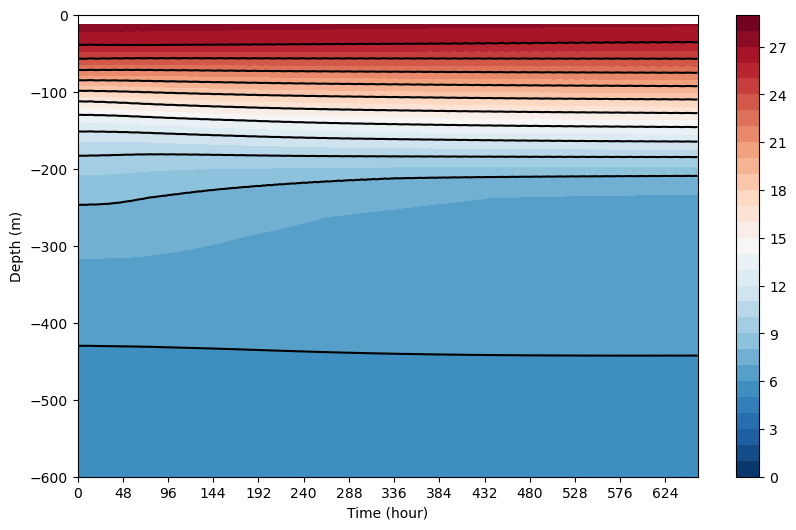

In [124]:
tref_ctrl = xr.open_dataset('theta_ref/theta_ref_exp7_ctrl.nc')
plt.figure(figsize=(10,6))
plt.contourf(np.arange(659),z_centers,tref_ctrl.theta_ref.values.T, levels=np.arange(0,30,1),cmap='RdBu_r')
plt.colorbar()
plt.contour(np.arange(659),z_centers,tref_ctrl.theta_ref.values.T, levels=np.arange(0,30,2),colors='k')
plt.ylim(-600,0)

plt.xticks(np.arange(0,659,48))

plt.xlabel('Time (hour)')
plt.ylabel('Depth (m)')



(-600.0, 0.0)

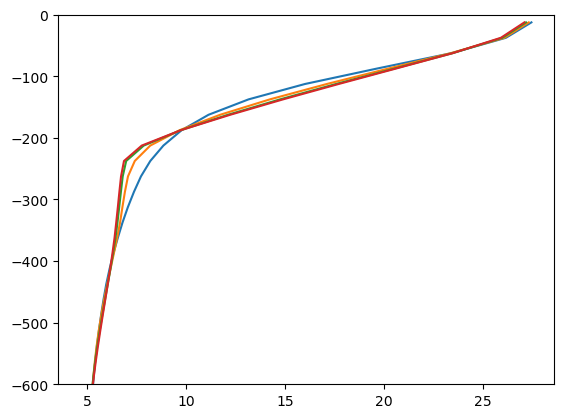

In [84]:
plt.plot(tref_ctrl.theta_ref.values[0,:],z_centers,)
plt.plot(tref_ctrl.theta_ref.values[240,:],z_centers,)
plt.plot(tref_ctrl.theta_ref.values[480,:],z_centers,)
plt.plot(tref_ctrl.theta_ref.values[650,:],z_centers,)
plt.ylim(-600,0)

In [23]:
theta_ini = ds_sn.THETA.isel(time=0)
theta_subset = theta_ini.isel(YC=slice(i_min, i_max+1), XC=slice(j_min, j_max+1))
theta_subset_ini = theta_subset.values

(26292960,)
(7775246,)


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


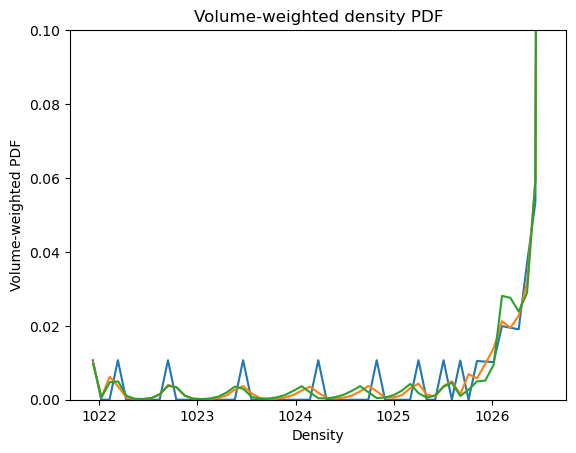

In [42]:
ds = ds_sn

i_min = 836
i_max = 1579
j_min = 458
j_max = 1077
# i_min = 836+50
# i_max = 836+50+120
# j_min = 458+200
# j_max = 458+200+30

# rho = rho_sulu[:,100:120,200:230]

rho_t = xr.DataArray(rho_sulu, dims = ('Z','YC','XC'))
# rA = ds['rA'].isel(YC=slice(i_min+100, i_min+120), XC=slice(j_min+200, j_min+230))
rA = ds['rA'].isel(YC=slice(i_min, i_max+1), XC=slice(j_min, j_max+1))*mask_sulu_bbox
drC = ds['drF']    # 1D vertical cell thickness (k,)
hFacC = ds.hFacC.isel(YC=slice(i_min, i_max+1), XC=slice(j_min, j_max+1))

# ensure drC is cell-centered 1D array
dr = drC
# compute cell center z coordinates (assuming drC gives thickness and we have faces)
# simple cumulative: top of domain z_top = 0, compute centers downward
# If ds contains zC or zMid use that instead; here we compute:
z_faces = ds.Zp1.values
# center heights: midpoints between faces; note sign convention: positive upward?
z_centers = ds.Z.values

# Expand dr and z to 3D shape of rho_t for volume computations
# rA has dims (j,i); expand to (k,j,i)
# hFacC maybe (k,j,i)
# create 3d dr array broadcastable to rho
# find spatial dims of rho_t
spatial_dims = rho_t.dims  # expect (k,j,i) or similar
k_dim = spatial_dims[0]    # assume vertical is first dim; adapt if necessary
# Broadcast dr (1D) to rho_t shape
dr_3d = xr.DataArray(dr.values, dims=(k_dim,), coords={k_dim: ds['drF'].coords['drF']})
dr_3d = dr_3d.broadcast_like(rho_t)

# Build rA 3D
rA_3d = rA.broadcast_like(rho_t)

hFacC_3d = hFacC.broadcast_like(rho_t)

# parcel volumes and densities (flatten)
vol = (rA_3d.astype(np.longdouble).values * dr_3d.astype(np.longdouble).values * hFacC_3d.astype(np.longdouble).values).ravel()   # 1D numpy array
print(vol.shape)
# dens = rho_t.values.ravel()
mask = vol > 0
vol = vol[mask]
# dens = dens[mask]
print(vol.shape)

# total horizontal area A_tot (sum rA over i,j)
# A_tot = rA.sum().compute().item()

# target reference layer volumes: V_ref_k = A_tot * dr_k (dr_k are ds[drC_name])
# V_ref_k = A_tot * dr.values   # numpy 1D length K
# V_ref_k = np.zeros(dr.shape[0])
# for k in tqdm(range(dr.shape[0])):
#     V_ref_k[k] = np.sum((rA_3d.astype(np.longdouble).values * dr_3d.astype(np.longdouble).values * hFacC_3d.astype(np.longdouble).values)[k,:,:])
#     # print(k,V_ref_k[k])

rho_ref_t=[]
# theta_t2 = []
for it in tqdm(range(0,241,120)):
    # print(it)
    theta_t0 = ds_sn.THETA.isel(time=it)
    theta_subset = theta_t0.isel(YC=slice(i_min, i_max+1), XC=slice(j_min, j_max+1))
    theta_subset_array = theta_subset.values

    rho_sulu_t = rho0*(1-alpha*(theta_subset_array-T0))
    # Eb, ref = compute_background_PE(rho_sulu_t, rA, hFacC, vol, mask, V_ref_k, z_centers, )   # or rho from equation of state
    # rho_ref_t.append(ref['rho_ref'])
    # theta_t2.append(theta_subset_array)

    rho_t = xr.DataArray(rho_sulu_t, dims = ('Z','YC','XC'))

    # find spatial dims of rho_t
    spatial_dims = rho_t.dims  # expect (k,j,i) or similar
    k_dim = spatial_dims[0]    # assume vertical is first dim; adapt if necessary
    # Broadcast dr (1D) to rho_t shape
    # dr_3d = xr.DataArray(dr.values, dims=(k_dim,), coords={k_dim: ds[drC_name].coords[drC_name]})
    # dr_3d = dr_3d.broadcast_like(rho_t)

    # Build rA 3D
    rA_3d = rA.broadcast_like(rho_t)

    hFacC_3d = hFacC.broadcast_like(rho_t)

    dens = rho_t.values.ravel()

    # remove zero-volume parcels (if any)
    # mask = vol > 0
    # vol = vol[mask]
    dens = dens[mask]

    # prepare sorted parcels by density (lightest -> heaviest)
    order = np.argsort(dens)   # ascending
    dens_sorted = dens[order]
    vol_sorted = vol[order]
    np.sum(vol_sorted)
    # fig, ax = plt.subplots(2,1,figsize=(8,6))
    # ax[0].plot(dens)
    # ax[0].set_xlim(0,20000)
    # plt.plot(dens_sorted)
    # ax[1].set_xlim(0,20000)
    # fig, ax = plt.subplots(2,1,figsize=(8,6))
    # ax[0].plot(vol)
    # # ax[0].set_xlim(0,20000)
    # ax[1].plot(vol_sorted)

    # dens, vol are 1D NumPy arrays (after compute(), ravel(), mask>0)
    # dens: density values
    # vol : corresponding cell volumes
    
    # choose bins
    nbins = 55
    bins = np.linspace(dens.min(), dens.max(), nbins + 1)
    
    # volume-weighted histogram
    hist, bin_edges = np.histogram(
        dens,
        bins=bins,
        weights=vol,
        density=False
    )
    
    # normalize to get PDF
    Vtot = vol.sum()

    pdf = hist / (Vtot * np.diff(bin_edges))
    # bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # plot
    # plt.figure()
    plt.plot(bin_centers, pdf*np.diff(bin_edges))
    plt.xlabel("Density")
    plt.ylabel("Volume-weighted PDF")
    plt.title("Volume-weighted density PDF")
    plt.ylim(0,0.1)

    
    # # fill reference layers from bottom to top:
    # # Winters stacks heaviest bottom; since dens_sorted is ascending (light->heavy),
    # # fill from the end for bottom layers. Simpler: reverse to heavy-first.
    # dens_h = dens_sorted[::-1]
    # vol_h = vol_sorted[::-1]   # now heavy -> light

    # K = len(V_ref_k)
    # rho_ref = np.zeros(K)
    # z_ref = z_centers  # numpy array of centers
    # Vref_used = V_ref_k.copy()

    # idx = 0         # index in dens_h parcels
    # vol_left = vol_h[idx] if len(vol_h)>0 else 0.0

    # # iterative fill each reference layer from bottom (k=0 bottom? depends on z ordering)
    # # Here we assume dr array was from top to bottom; z_centers from top->down.
    # # We want k indices bottom->top, so reverse arrays:
    # Vref_bottomup = V_ref_k[::-1]
    # z_bottomup = z_centers[::-1]

    # # sumV_domain = 0
    # for kk in range(K):
    #     # print(kk,sumV_domain)
    #     V_target = Vref_bottomup[kk]
    #     sum_rhoV = 0.0
    #     sumV_filled = 0.0
    #     # fill this layer
    #     # while sumV_filled < V_target:
    #     while V_target-sumV_filled>0.1:
    #         if idx >= len(dens_h):
    #             print(idx)
    #             print(len(dens_h))
    #             raise RuntimeError(f"Ran out of parcels while filling reference layers.{idx}")
    #         take = min(vol_left, V_target - sumV_filled)
    #         # print(take, vol_left, V_target - sumV_filled)
    #         sum_rhoV += dens_h[idx] * take
    #         sumV_filled += take
    #         vol_left -= take
    #         # sumV_domain += take
    #         if vol_left <= 1e-16:
    #             # move to next parcel
    #             idx += 1
    #             if idx < len(vol_h):
    #                 vol_left = vol_h[idx]
            
    #     rho_ref[K-1-kk] = sum_rhoV / V_target  # assign back in top->bottom order

    # # compute Eb:
    # # Use z_centers and V_ref_k with same ordering as rho_ref
    # # Decide z sign: Winters uses z positive upward. If z_centers from top=0 increasing downward, convert to actual heights.
    # # Here we assume z_centers is depth increasing downward; convert to height measured from bottom or top as needed.
    # # We'll assume z_centers are heights above bottom. Adjust if needed.
    # Eb = g * np.sum(rho_ref * z_centers * V_ref_k)

In [34]:
np.isclose(np.sum(pdf * np.diff(bin_edges)), 1.0)


1368.0

In [38]:
pdf * np.diff(bin_edges)

array([9.32528929e-03, 6.24350931e-04, 4.54357102e-04, 2.78819745e-03,
       4.79537920e-03, 2.27905461e-03, 7.06797665e-04, 2.46498064e-04,
       1.47243081e-04, 1.44972499e-04, 2.34727687e-04, 5.05149481e-04,
       1.17275667e-03, 2.33093877e-03, 2.91583236e-03, 2.07674611e-03,
       9.11492535e-04, 3.17542527e-04, 1.40253412e-04, 1.14185645e-04,
       1.63228394e-04, 2.96947900e-04, 5.53819010e-04, 9.92837833e-04,
       1.73891751e-03, 2.51238385e-03, 2.42934831e-03, 1.29670948e-03,
       4.39377963e-04, 1.82916144e-04, 1.29158173e-04, 2.32591779e-04,
       3.98001530e-04, 6.19365410e-04, 1.01136012e-03, 1.55542545e-03,
       2.31402326e-03, 2.48161262e-03, 1.37895842e-03, 4.55323634e-04,
       1.93926577e-04, 2.25476670e-04, 3.96727548e-04, 6.21604957e-04,
       9.58987967e-04, 1.42828290e-03, 2.09140006e-03, 2.64454015e-03,
       1.66903960e-03, 5.30210971e-04, 2.63420429e-04, 3.85242726e-04,
       6.36954004e-04, 1.01228886e-03, 1.64839567e-03, 2.63966158e-03,
      

(-600.0, 0.0)

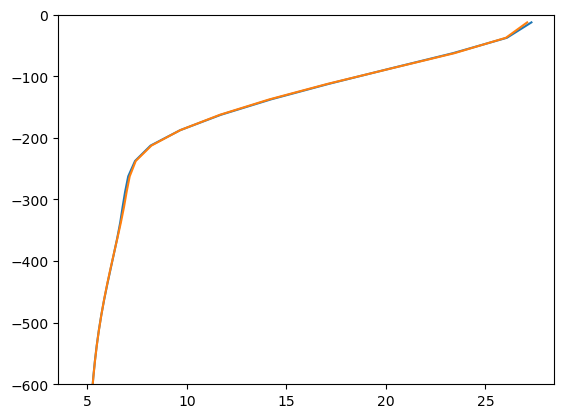

In [19]:
rho_ref_t2 = np.array(ref['rho_ref'])
theta_ref_t2 = 1/alpha*(1-rho_ref_t2/rho0)+T0
theta_subset_array[theta_subset_array==0] = np.nan
theta_subset_array_hmean = np.nanmean(theta_subset_array, axis=(1,2))

plt.plot(theta_ref_t2,z_centers)
plt.plot(theta_subset_array_hmean,z_centers)
plt.ylim(-600,0)

## OLDDDDDD

In [ ]:
rho = rho_sulu_t

rho_t = xr.DataArray(rho, dims = ('Z','YC','XC'))
# rA = ds[rA_name].isel(YC=slice(i_min, i_max+1), XC=slice(j_min, j_max+1))
# drC = ds[drC_name]    # 1D vertical cell thickness (k,)
# hFacC = ds.hFacC.isel(YC=slice(i_min, i_max+1), XC=slice(j_min, j_max+1))

# # ensure drC is cell-centered 1D array
# dr = drC
# # compute cell center z coordinates (assuming drC gives thickness and we have faces)
# # simple cumulative: top of domain z_top = 0, compute centers downward
# # If ds contains zC or zMid use that instead; here we compute:
# z_faces = ds.Zp1.values
# # center heights: midpoints between faces; note sign convention: positive upward?
# z_centers = ds.Z.values

# Expand dr and z to 3D shape of rho_t for volume computations
# rA has dims (j,i); expand to (k,j,i)
# hFacC maybe (k,j,i)
# create 3d dr array broadcastable to rho
# find spatial dims of rho_t
spatial_dims = rho_t.dims  # expect (k,j,i) or similar
k_dim = spatial_dims[0]    # assume vertical is first dim; adapt if necessary
# Broadcast dr (1D) to rho_t shape
# dr_3d = xr.DataArray(dr.values, dims=(k_dim,), coords={k_dim: ds[drC_name].coords[drC_name]})
# dr_3d = dr_3d.broadcast_like(rho_t)

# Build rA 3D
rA_3d = rA.broadcast_like(rho_t)

hFacC_3d = hFacC.broadcast_like(rho_t)

# parcel volumes and densities (flatten)
# vol = (rA_3d.values * dr_3d.values * hFacC_3d.values).ravel()   # 1D numpy array

dens = rho_t.values.ravel()

# remove zero-volume parcels (if any)
# mask = vol > 0
# vol = vol[mask]
dens = dens[mask]

# total horizontal area A_tot (sum rA over i,j)
# A_tot = rA.sum().compute().item()

# target reference layer volumes: V_ref_k = A_tot * dr_k (dr_k are ds[drC_name])
# V_ref_k = A_tot * dr.values   # numpy 1D length K
# V_ref_k = np.zeros(dr.shape[0])
# for k in range(dr.shape[0]):
#     V_ref_k[k] = np.sum((rA_3d.astype(np.double).values * dr_3d.astype(np.double).values * hFacC_3d.astype(np.double).values)[k,:,:])


# prepare sorted parcels by density (lightest -> heaviest)
order = np.argsort(dens)   # ascending
dens_sorted = dens[order]
vol_sorted = vol[order]
np.sum(vol_sorted)

# fill reference layers from bottom to top:
# Winters stacks heaviest bottom; since dens_sorted is ascending (light->heavy),
# fill from the end for bottom layers. Simpler: reverse to heavy-first.
dens_h = dens_sorted[::-1]
vol_h = vol_sorted[::-1]   # now heavy -> light

K = len(V_ref_k)
rho_ref = np.zeros(K)
z_ref = z_centers  # numpy array of centers
Vref_used = V_ref_k.copy()

idx = 0         # index in dens_h parcels
vol_left = vol_h[idx] if len(vol_h)>0 else 0.0

# iterative fill each reference layer from bottom (k=0 bottom? depends on z ordering)
# Here we assume dr array was from top to bottom; z_centers from top->down.
# We want k indices bottom->top, so reverse arrays:
Vref_bottomup = V_ref_k[::-1]
z_bottomup = z_centers[::-1]

sumV_domain = 0
for kk in range(K):
    
    print(kk,sumV_domain)
    V_target = Vref_bottomup[kk]
    sum_rhoV = 0.0
    sumV_filled = 0.0
    # fill this layer
    # while sumV_filled < V_target:
    while V_target-sumV_filled>0.1:
        if idx >= len(dens_h):
            print(idx)
            print(len(dens_h))
            raise RuntimeError(f"Ran out of parcels while filling reference layers.{idx}")
        take = min(vol_left, V_target - sumV_filled)
        # print(take, vol_left, V_target - sumV_filled)
        sum_rhoV += dens_h[idx] * take
        sumV_filled += take
        vol_left -= take
        sumV_domain += take
        if vol_left <= 1e-16:
            # move to next parcel
            idx += 1
            if idx < len(vol_h):
                vol_left = vol_h[idx]
    rho_ref[K-1-kk] = sum_rhoV / V_target  # assign back in top->bottom order

# compute Eb:
# Use z_centers and V_ref_k with same ordering as rho_ref
# Decide z sign: Winters uses z positive upward. If z_centers from top=0 increasing downward, convert to actual heights.
# Here we assume z_centers is depth increasing downward; convert to height measured from bottom or top as needed.
# We'll assume z_centers are heights above bottom. Adjust if needed.
Eb = g * np.sum(rho_ref * z_centers * V_ref_k)


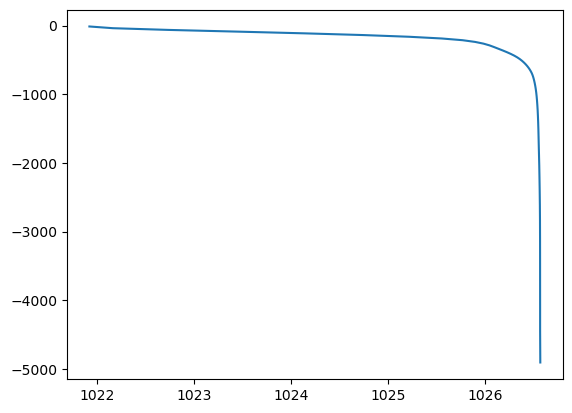

In [233]:
plt.plot(rho_ref,z_centers)